In [327]:
import os
import tarfile
import urllib
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import dask.dataframe as dd
import dask.array as da
import dask.bag as dbs
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)
import datetime as dt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib

In [316]:
# from IPython.display import display
# pd.options.display.float_format = '{:,.2f}'.format

In [3]:
countiesdf = pd.read_csv('county.csv', index_col = 0)
pricesdf = pd.read_csv('price.csv', index_col = 0)
productsdf = pd.read_csv('product.csv', index_col = 0)
storesdf = pd.read_csv('store.csv', index_col = 0)
vendorsdf = pd.read_csv('vendor.csv', index_col = 0)
categoriesdf = pd.read_csv('category.csv', index_col = 0)
transactionsdf = pd.read_csv('transaction.csv', index_col = 0)

In [137]:
productsdf['ItemNumber'] = productsdf['ItemNumber'].astype(str)

In [4]:
transactionsdf['Sale']=transactionsdf['Sale'].str.replace(',','')
transactionsdf['Sale']=pd.to_numeric(transactionsdf['Sale'])
transactionsdf['Sale']=transactionsdf['Sale'].fillna(0)
transactionsdf['Date'] = pd.to_datetime(transactionsdf['Date'], 
                                        infer_datetime_format=True)


In [165]:
transactions_2019_2022 = transactionsdf.loc[transactionsdf['Date'] > '2018-12-31' ]

In [166]:
transactions_2019_2022

Date  StoreNumber  Category  VendorNumber  ItemNumber  \
InvoiceNumber                                                                 
INV-16677300023 2019-01-02         4361   1031100           300       36901   
INV-16701200024 2019-01-02         4256   1081400            65       82866   
INV-16696300004 2019-01-02         4648   1041100           370       32232   
INV-16677300007 2019-01-02         4361   1062400           260       43334   
INV-16681900007 2019-01-02         5286   1081400           434       84457   
...                    ...          ...       ...           ...         ...   
INV-46957100177 2022-04-29         2560   1031100           421       35315   
INV-46962900044 2022-04-29         4448   1052100           420       48105   
INV-46954700009 2022-04-29         4617   1031100           260       37996   
INV-46968300023 2022-04-29         2649   1031200           380       41692   
INV-46979000088 2022-04-29         2618   1022200           370       88186   

                 BottlesSold  Volume(Gallons)    Sale  
InvoiceNumber                                          
INV-16677300023            0              NaN    7.05  
INV-16701200024            0              NaN   38.84  
INV-16696300004            0              NaN  140.16  
INV-16677300007            0              NaN  120.00  
INV-16681900007            0              NaN   97.56  
...                      ...              ...     ...  
INV-46957100177           12              NaN   60.72  
INV-46962900044            2              NaN   37.48  
INV-46954700009            2              NaN   24.76  
INV-46968300023            6              NaN  103.50  
INV-46979000088            3              NaN   67.47  

[8420163 rows x 8 columns]

In [415]:
college_towns = ['Iowa City', 'Ames', 'Cedar Falls/Waterloo', 'Dubuque',
                 'Des Moines', 'Davenport' ]

des_moines_zc = [x for x in range(50301, 50341)]

iowa_city_zips = [52240, 52242, 52243, 52244, 52245,52246]
ames_zips = [50010, 50011, 50012, 50013, 50014]
cedar_waterloo_zips = [50613] + [50701, 50702, 50703, 50704, 50705, 50706, 50707]
dubuque_zips = [ 52001, 52002, 52003,52004, 52099]
des_moines_zips = [x for x in range(50301, 50341)]
davenport_zips = [52801, 52802, 
                    52803, 52804, 52805, 52806, 52807, 52808,52809]


college_zipcodes = iowa_city_zips + ames_zips +  cedar_waterloo_zips + dubuque_zips + \
des_moines_zc + davenport_zips 



In [417]:
# storesdf['ZipCode']=storesdf['ZipCode'].str.replace('-','')
storesdf.loc[:, "ZipCode"] = storesdf["ZipCode"].astype(int)

storesdf.loc[storesdf.ZipCode.isin(des_moines_zips), 'City'] = 'Des Moines'
storesdf.loc[storesdf.ZipCode.isin(iowa_city_zips), 'City'] = 'Iowa City'
storesdf.loc[storesdf.ZipCode.isin(ames_zips), 'City'] = 'Ames'
storesdf.loc[storesdf.ZipCode.isin(cedar_waterloo_zips), 'City'] = 'Cedar Falls/Waterloo'
storesdf.loc[storesdf.ZipCode.isin(dubuque_zips), 'City'] = 'Dubuque'
storesdf.loc[storesdf.ZipCode.isin(davenport_zips), 'City'] = 'Davenport'


In [51]:
college_storesdf = storesdf.copy()
college_storesdf= college_storesdf.reset_index()
college_storesdf = college_storesdf.drop(columns = ['index'])
college_storesdf = college_storesdf[college_storesdf["ZipCode"].isin(college_zipcodes)]

college_storesdf


StoreNumber                             StoreName        City  ZipCode  \
3            5856           Station Mart #1 - Evansdale    Waterloo    50707   
6            4265                Kwik Stop 3 / Waterloo    Waterloo    50702   
7            2625  Hy-Vee Wine & Spirits #2 / Davenport   Davenport    52804   
12           2532     Hy-Vee Food Store #2 / Des Moines  Des Moines    50317   
13           2635                 Hy-Vee #4 / Davenport   Davenport    52807   
...           ...                                   ...         ...      ...   
2710         5136                          Urban Liquor  Des Moines    50322   
2713         4333                             Liquorama    Waterloo    50703   
2716         4830                             JCL Store  Des Moines    50325   
2719         5152                   Texas Street Market    Waterloo    50702   
2726         9048              Artisan Grain Distillery   Davenport    52801   

      CountyNumber      County  
3              7.0  BLACK HAWK  
6              7.0  BLACK HAWK  
7             82.0       SCOTT  
12            77.0        POLK  
13            82.0       SCOTT  
...            ...         ...  
2710          77.0        Polk  
2713           7.0  Black Hawk  
2716          77.0        Polk  
2719           7.0  Black Hawk  
2726          82.0       SCOTT  

[588 rows x 6 columns]

In [451]:
transactionsdf

Date  StoreNumber  Category  VendorNumber  ItemNumber  \
InvoiceNumber                                                                 
S03401400012    2012-01-03         2233   1081315           380       84636   
S03389000026    2012-01-03         3583   1011200            65       20247   
S03387100016    2012-01-03         4132   1081200           300       65199   
S03411000130    2012-01-03         2625   1031200           260       41715   
S03377200020    2012-01-03         4438   1062310           260       43331   
...                    ...          ...       ...           ...         ...   
INV-46957100177 2022-04-29         2560   1031100           421       35315   
INV-46962900044 2022-04-29         4448   1052100           420       48105   
INV-46954700009 2022-04-29         4617   1031100           260       37996   
INV-46968300023 2022-04-29         2649   1031200           380       41692   
INV-46979000088 2022-04-29         2618   1022200           370       88186   

                 BottlesSold  Volume(Gallons)    Sale  
InvoiceNumber                                          
S03401400012              12              NaN  124.92  
S03389000026               2              NaN   13.90  
S03387100016               4              NaN   71.96  
S03411000130               2              NaN   23.12  
S03377200020               2              NaN   14.50  
...                      ...              ...     ...  
INV-46957100177           12              NaN   60.72  
INV-46962900044            2              NaN   37.48  
INV-46954700009            2              NaN   24.76  
INV-46968300023            6              NaN  103.50  
INV-46979000088            3              NaN   67.47  

[23774991 rows x 8 columns]

In [574]:
#c_transactions = collegetown transactions
c_transactions = transactionsdf.copy()
c_transactions = pd.merge(c_transactions, storesdf, on= 'StoreNumber')
# c_transactions['ZipCode']=c_transactions['ZipCode'].str.replace('-','')
c_transactions.loc[:, "ZipCode"] = c_transactions["ZipCode"].astype(int)
c_transactions = c_transactions[c_transactions["ZipCode"].isin(college_zipcodes)]
c_transactions = pd.merge(c_transactions, categoriesdf, on= 'Category')
c_transactions['Date'] = pd.to_datetime(c_transactions['Date'], 
                                        infer_datetime_format=True)
c_transactions['Hyvee?'] = np.where(c_transactions['StoreName'].str.contains('Hy-Vee'),1,0)

c_transactions.loc[c_transactions.ZipCode.isin(cedar_waterloo_zips), 'City'] = 'Cedar Falls/Waterloo'


In [575]:
c_transactions

Date  StoreNumber  Category  VendorNumber  ItemNumber  \
0       2012-01-03         2625   1031200           260       41715   
1       2012-01-03         2625   1031200           380       41696   
2       2012-01-03         2625   1031200           260       41078   
3       2012-01-03         2625   1031200           380       41704   
4       2012-01-03         2625   1031200           380       41694   
...            ...          ...       ...           ...         ...   
6898884 2013-09-04         4669    101220           885      901369   
6898885 2013-10-24         4669    101220           885      901369   
6898886 2013-12-12         4669    101220           885      901369   
6898887 2014-04-17         4669    101220           885      901369   
6898888 2014-08-20         4669    101220           885      901369   

         BottlesSold  Volume(Gallons)    Sale  \
0                  2              NaN   23.12   
1                  0              NaN   37.32   
2                  0              NaN  134.76   
3                  0              NaN   18.66   
4                  0              NaN  391.32   
...              ...              ...     ...   
6898884            3              NaN  231.87   
6898885            3              NaN  231.87   
6898886            6              NaN  463.74   
6898887            3              NaN  235.68   
6898888            3              NaN  235.68   

                                    StoreName        City  ZipCode  \
0        Hy-Vee Wine & Spirits #2 / Davenport   Davenport    52804   
1        Hy-Vee Wine & Spirits #2 / Davenport   Davenport    52804   
2        Hy-Vee Wine & Spirits #2 / Davenport   Davenport    52804   
3        Hy-Vee Wine & Spirits #2 / Davenport   Davenport    52804   
4        Hy-Vee Wine & Spirits #2 / Davenport   Davenport    52804   
...                                       ...         ...      ...   
6898884                 Vom Fass / Des Moines  Des Moines    50312   
6898885                 Vom Fass / Des Moines  Des Moines    50312   
6898886                 Vom Fass / Des Moines  Des Moines    50312   
6898887                 Vom Fass / Des Moines  Des Moines    50312   
6898888                 Vom Fass / Des Moines  Des Moines    50312   

         CountyNumber County             CategoryName SpecificCategory  Hyvee?  
0                82.0  SCOTT  American Flavored Vodka            Vodka       1  
1                82.0  SCOTT  American Flavored Vodka            Vodka       1  
2                82.0  SCOTT  American Flavored Vodka            Vodka       1  
3                82.0  SCOTT  American Flavored Vodka            Vodka       1  
4                82.0  SCOTT  American Flavored Vodka            Vodka       1  
...               ...    ...                      ...              ...     ...  
6898884          77.0   POLK                   whisky          Whiskey       0  
6898885          77.0   POLK                   whisky          Whiskey       0  
6898886          77.0   POLK                   whisky          Whiskey       0  
6898887          77.0   POLK                   whisky          Whiskey       0  
6898888          77.0   POLK                   whisky          Whiskey       0  

[6898889 rows x 16 columns]

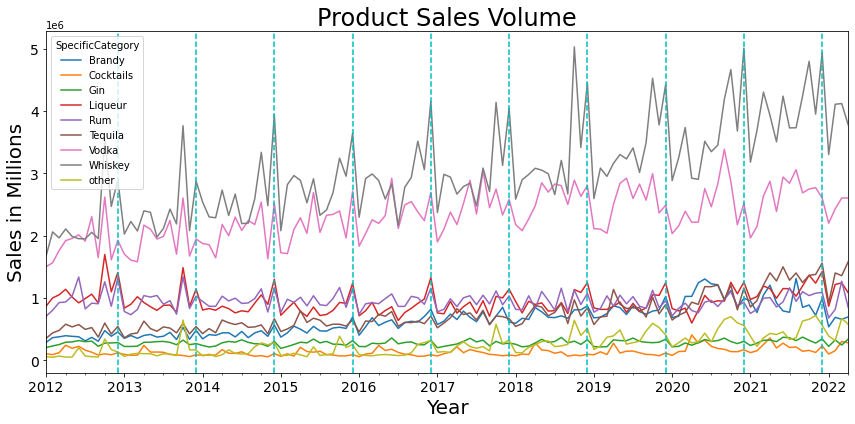

In [590]:
#Total Sales in all collegetowns
totalItems = c_transactions.groupby(['SpecificCategory', 'ItemNumber', pd.Grouper(key='Date', freq='M')]).agg(Sale=('Sale','sum'))
totalItems = totalItems.reset_index('Date').pivot_table(index='Date', values='Sale', columns='SpecificCategory', aggfunc=np.sum)
totalItems = totalItems.fillna(0)


f,ax = plt.subplots(figsize = (12,6))
totalItems.plot(ax=ax)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_title('Product Sales Volume', fontsize = 24)
ax.set_ylabel('Sales in Millions', fontsize = 20)
ax.set_xlabel('Year', fontsize = 20)
for i in range(2012,2023):
    dec = plt.axvline(dt.datetime(i,12,31),color='c',linestyle='--', label='December 31')
f.tight_layout()

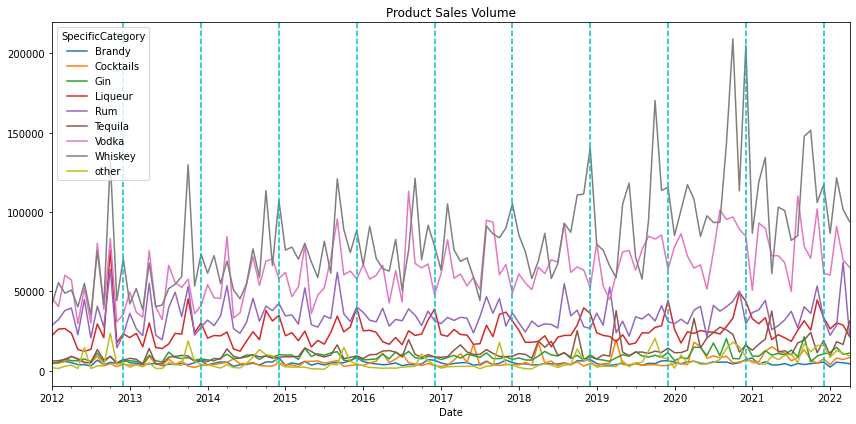

In [112]:
#Total Sales in hyvee stores in Ames

totalItems = c_transactions[c_transactions['ZipCode'].isin(ames_zips)]
totalItems = totalItems[totalItems['StoreNumber'].isin(store_HyVeeC.StoreNumber)]
totalItems = totalItems.groupby(['SpecificCategory', 'ItemNumber', pd.Grouper(key='Date', freq='M')]).agg(Sale=('Sale','sum'))
totalItems = totalItems.reset_index('Date').pivot_table(index='Date', values='Sale', columns='SpecificCategory', aggfunc=np.sum)
totalItems = totalItems.fillna(0)


f,ax = plt.subplots(figsize = (12,6))
totalItems.plot(ax=ax)
ax.set_title('Product Sales Volume')
for i in range(2012,2023):
    dec = plt.axvline(dt.datetime(i,12,31),color='c',linestyle='--', label='December 31')
f.tight_layout()



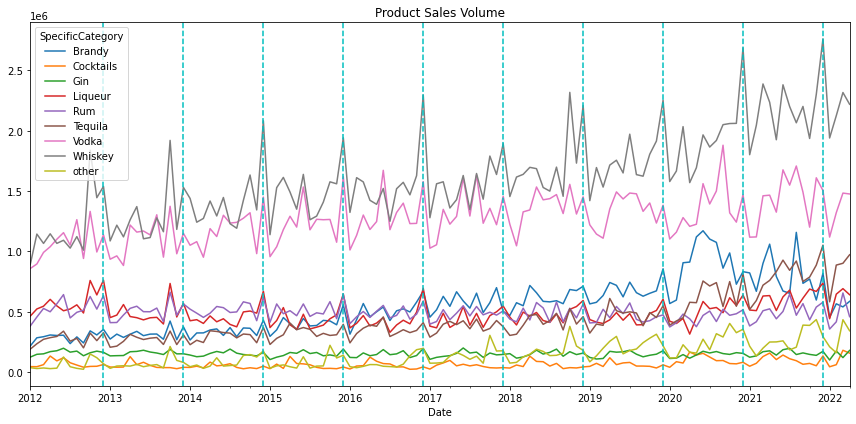

In [113]:
#Total Sales in non-hyvee stores in Ames

totalItems = c_transactions[~c_transactions['ZipCode'].isin(ames_zips)]
totalItems = totalItems[~totalItems['StoreNumber'].isin(store_HyVeeC.StoreNumber)]
totalItems = totalItems.groupby(['SpecificCategory', 'ItemNumber', pd.Grouper(key='Date', freq='M')]).agg(Sale=('Sale','sum'))
totalItems = totalItems.reset_index('Date').pivot_table(index='Date', values='Sale', columns='SpecificCategory', aggfunc=np.sum)
totalItems = totalItems.fillna(0)


f,ax = plt.subplots(figsize = (12,6))
totalItems.plot(ax=ax)
ax.set_title('Product Sales Volume')
for i in range(2012,2023):
    dec = plt.axvline(dt.datetime(i,12,31),color='c',linestyle='--', label='December 31')
f.tight_layout()

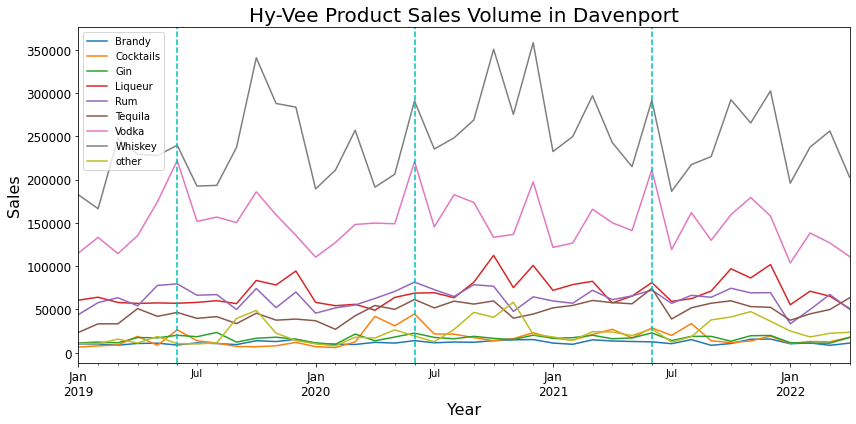

In [625]:
#Total Sales in hyvee stores in Davenport
totalItems = transactions_2019_2022.copy()
totalItems = totalItems.merge(storesdf, on = 'StoreNumber')
totalItems = totalItems.merge(categoriesdf, on = 'Category')
totalItems = totalItems[totalItems['ZipCode'].isin(davenport_zips)]
totalItems = totalItems[totalItems['StoreNumber'].isin(store_HyVeeC.StoreNumber)]
totalItems = totalItems.groupby(['SpecificCategory', 'ItemNumber', pd.Grouper(key='Date', freq='M')]).agg(Sale=('Sale','sum'))
totalItems = totalItems.reset_index('Date').pivot_table(index='Date', values='Sale', columns='SpecificCategory', aggfunc=np.sum)
totalItems = totalItems.fillna(0)


f,ax = plt.subplots(figsize = (12,6))
totalItems.plot(ax=ax)
plt.legend(loc = 'upper left')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_title('Hy-Vee Product Sales Volume in Davenport', fontsize = 20)
ax.set_ylabel('Sales', fontsize = 16)
ax.set_xlabel('Year', fontsize = 16)
for i in range(2012,2023):
    dec = plt.axvline(dt.datetime(i,6,30),color='c',linestyle='--', label='December 31')
f.tight_layout()

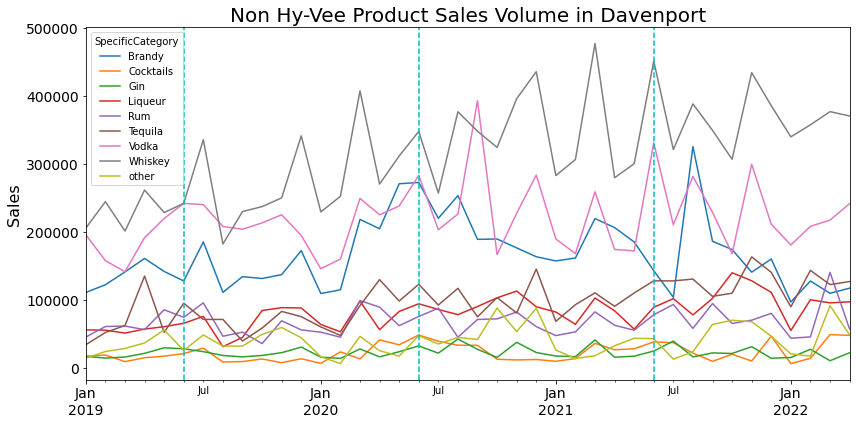

In [657]:
#Total Sales in non-hyvee stores in davenport
totalItems = transactions_2019_2022.copy()
totalItems = totalItems.merge(storesdf, on = 'StoreNumber')
totalItems = totalItems.merge(categoriesdf, on = 'Category')
totalItems = totalItems[totalItems['ZipCode'].isin(davenport_zips)]
totalItems = totalItems[~totalItems['StoreNumber'].isin(store_HyVeeC.StoreNumber)]
totalItems = totalItems.groupby(['SpecificCategory', 'ItemNumber', pd.Grouper(key='Date', freq='M')]).agg(Sale=('Sale','sum'))
totalItems = totalItems.reset_index('Date').pivot_table(index='Date', values='Sale', columns='SpecificCategory', aggfunc=np.sum)
totalItems = totalItems.fillna(0)


f,ax = plt.subplots(figsize = (12,6))
totalItems.plot(ax=ax, xlabel = '')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_title('Non Hy-Vee Product Sales Volume in Davenport', fontsize = 20)
ax.set_ylabel('Sales', fontsize = 16)
# ax.get_yaxis().set_major_formatter(
#     matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x)/1000000, ',')))
for i in range(2012,2023):
    dec = plt.axvline(dt.datetime(i,6,30),color='c',linestyle='--', label='December 31')
f.tight_layout()

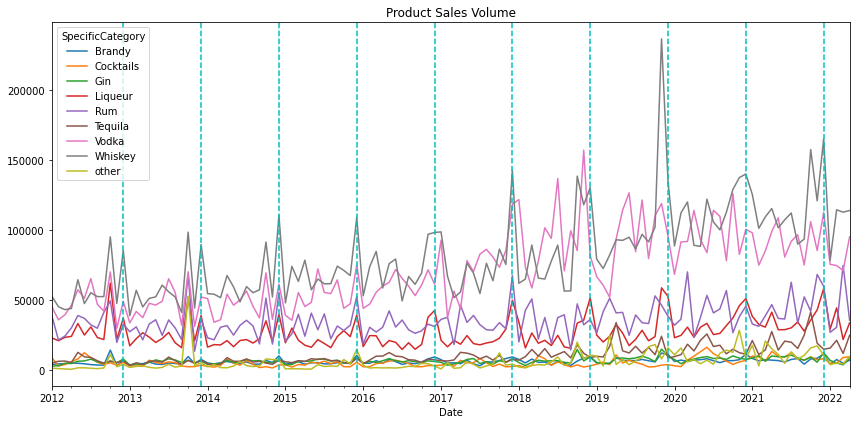

In [120]:
#Total Sales in hyvee stores in dubuque

totalItems = c_transactions[c_transactions['ZipCode'].isin(dubuque_zips)]
totalItems = totalItems[totalItems['StoreNumber'].isin(store_HyVeeC.StoreNumber)]
totalItems = totalItems.groupby(['SpecificCategory', 'ItemNumber', pd.Grouper(key='Date', freq='M')]).agg(Sale=('Sale','sum'))
totalItems = totalItems.reset_index('Date').pivot_table(index='Date', values='Sale', columns='SpecificCategory', aggfunc=np.sum)
totalItems = totalItems.fillna(0)


f,ax = plt.subplots(figsize = (12,6))
totalItems.plot(ax=ax)
ax.set_title('Product Sales Volume')
for i in range(2012,2023):
    dec = plt.axvline(dt.datetime(i,12,31),color='c',linestyle='--', label='December 31')
f.tight_layout()

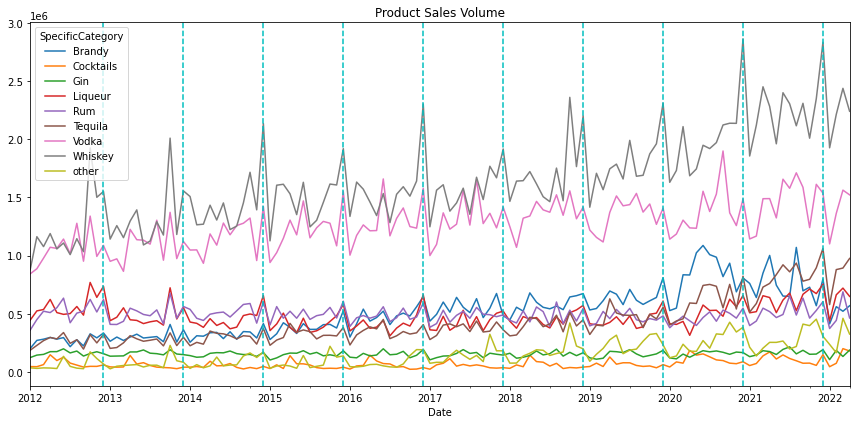

In [121]:
#Total Sales in non-hyvee stores in dubuque

totalItems = c_transactions[~c_transactions['ZipCode'].isin(dubuque_zips)]
totalItems = totalItems[~totalItems['StoreNumber'].isin(store_HyVeeC.StoreNumber)]
totalItems = totalItems.groupby(['SpecificCategory', 'ItemNumber', pd.Grouper(key='Date', freq='M')]).agg(Sale=('Sale','sum'))
totalItems = totalItems.reset_index('Date').pivot_table(index='Date', values='Sale', columns='SpecificCategory', aggfunc=np.sum)
totalItems = totalItems.fillna(0)


f,ax = plt.subplots(figsize = (12,6))
totalItems.plot(ax=ax)
ax.set_title('Product Sales Volume')
for i in range(2012,2023):
    dec = plt.axvline(dt.datetime(i,12,31),color='c',linestyle='--', label='December 31')
f.tight_layout()

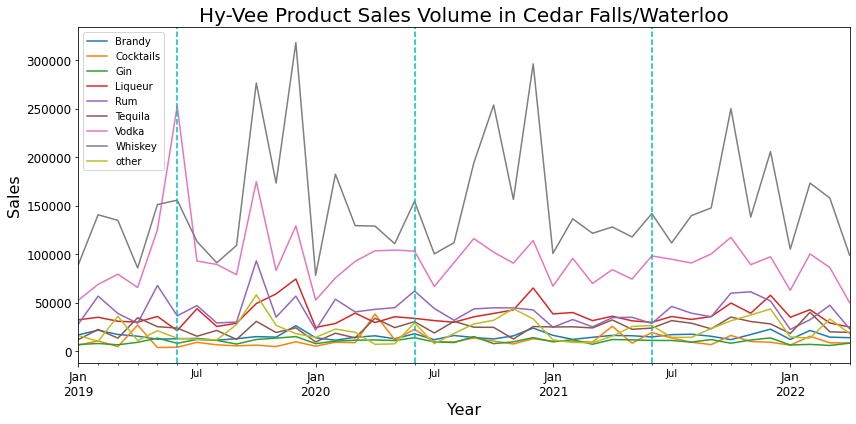

In [621]:
#Total Sales in hyvee stores in Waterloo
totalItems = transactions_2019_2022.copy()
totalItems = totalItems.merge(storesdf, on = 'StoreNumber')
totalItems = totalItems.merge(categoriesdf, on = 'Category')
totalItems = totalItems[totalItems['ZipCode'].isin(cedar_waterloo_zips)]
totalItems = totalItems[totalItems['StoreNumber'].isin(store_HyVeeC.StoreNumber)]
totalItems = totalItems.groupby(['SpecificCategory', 'ItemNumber', pd.Grouper(key='Date', freq='M')]).agg(Sale=('Sale','sum'))
totalItems = totalItems.reset_index('Date').pivot_table(index='Date', values='Sale', columns='SpecificCategory', aggfunc=np.sum)
totalItems = totalItems.fillna(0)


f,ax = plt.subplots(figsize = (12,6))
totalItems.plot(ax=ax)
plt.legend(loc = 'upper left')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_title('Hy-Vee Product Sales Volume in Cedar Falls/Waterloo', fontsize = 20)
ax.set_ylabel('Sales', fontsize = 16)
ax.set_xlabel('Year', fontsize = 16)

for i in range(2012,2023):
    dec = plt.axvline(dt.datetime(i,6,30),color='c',linestyle='--', label='December 31')
f.tight_layout()

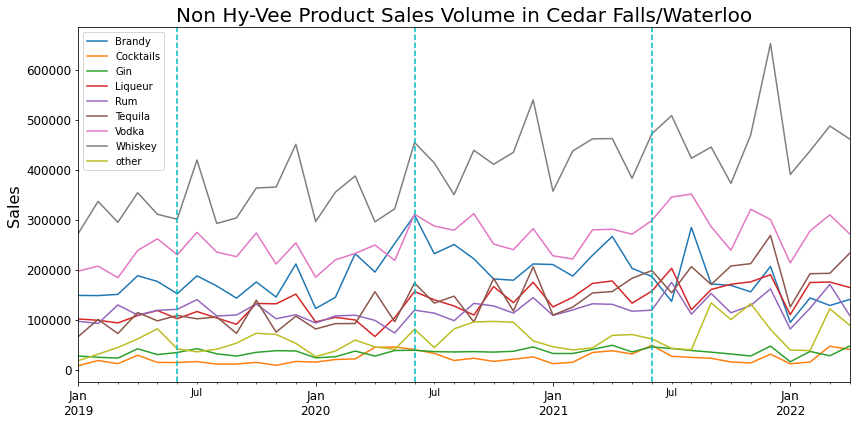

In [656]:
#Total Sales in non-hyvee stores in cedar/falls waterloo
totalItems = transactions_2019_2022.copy()
totalItems = totalItems.merge(storesdf, on = 'StoreNumber')
totalItems = totalItems.merge(categoriesdf, on = 'Category')
totalItems = totalItems[totalItems['ZipCode'].isin(cedar_waterloo_zips)]
totalItems = totalItems[~totalItems['StoreNumber'].isin(store_HyVeeC.StoreNumber)]
totalItems = totalItems.groupby(['SpecificCategory', 'ItemNumber', pd.Grouper(key='Date', freq='M')]).agg(Sale=('Sale','sum'))
totalItems = totalItems.reset_index('Date').pivot_table(index='Date', values='Sale', columns='SpecificCategory', aggfunc=np.sum)
totalItems = totalItems.fillna(0)


f,ax = plt.subplots(figsize = (12,6))
totalItems.plot(ax=ax, xlabel = '')
plt.legend(loc = 'upper left')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_title('Non Hy-Vee Product Sales Volume in Cedar Falls/Waterloo', fontsize = 20)
ax.set_ylabel('Sales', fontsize = 16)
# ax.get_yaxis().set_major_formatter(
#     matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x)/1000000, ',')))
for i in range(2012,2023):
    dec = plt.axvline(dt.datetime(i,6,30),color='c',linestyle='--', label='December 31')
f.tight_layout()

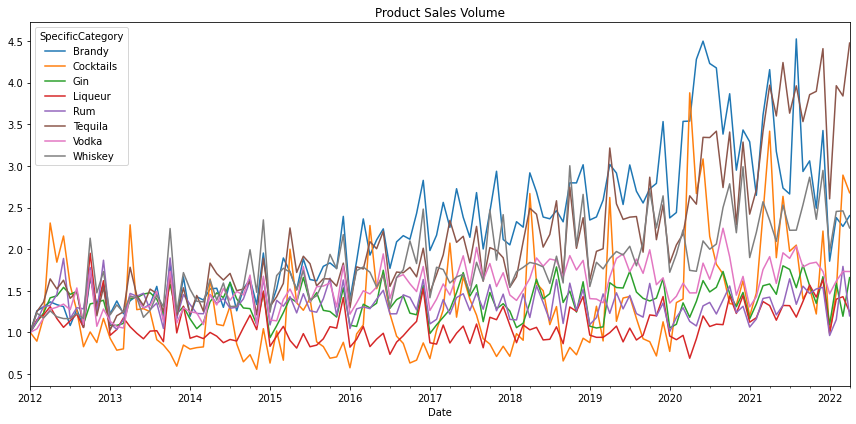

In [92]:
#Total Sales in all collegetowns
totalItems = c_transactions.copy()
totalItems = totalItems[totalItems['SpecificCategory'] != 'other']
totalItems = totalItems.groupby(['SpecificCategory', 'ItemNumber', pd.Grouper(key='Date', freq='M')]).agg(Sale=('Sale','sum'))
totalItems = totalItems.reset_index('Date').pivot_table(index='Date', values='Sale', columns='SpecificCategory', aggfunc=np.sum)
totalItems = totalItems.fillna(0)

for col in totalItems.columns:
    totalItems[col] = totalItems[col]/totalItems[col][0]

f,ax = plt.subplots(figsize = (12,6))
totalItems.plot(ax=ax)
ax.set_title('Product Sales Volume')
f.tight_layout()

In [564]:
 totalStores.count().max()

43

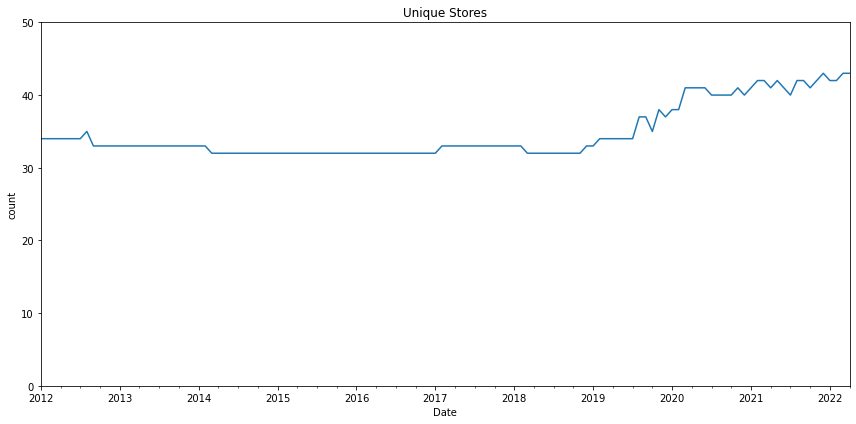

In [568]:
#total unique hyvee stores in collegetowns
totalStores = c_transactions[c_transactions['StoreNumber'].isin(store_HyVeeC['StoreNumber'])].groupby(
    ['StoreNumber', pd.Grouper(key='Date', freq='M')])['Sale'].sum()
totalStores = totalStores.reset_index('Date').pivot_table(index='StoreNumber', columns='Date', aggfunc=np.sum)
totalStores.columns = totalStores.columns.droplevel(0)

f,ax = plt.subplots(figsize = (12,6))
totalStores.count().plot()
ax.set_title('Unique Stores')
ax.set_ylabel('count')
ax.set_ylim(bottom=0, top=50)
f.tight_layout()

In [572]:
totalStores.count().min()

176

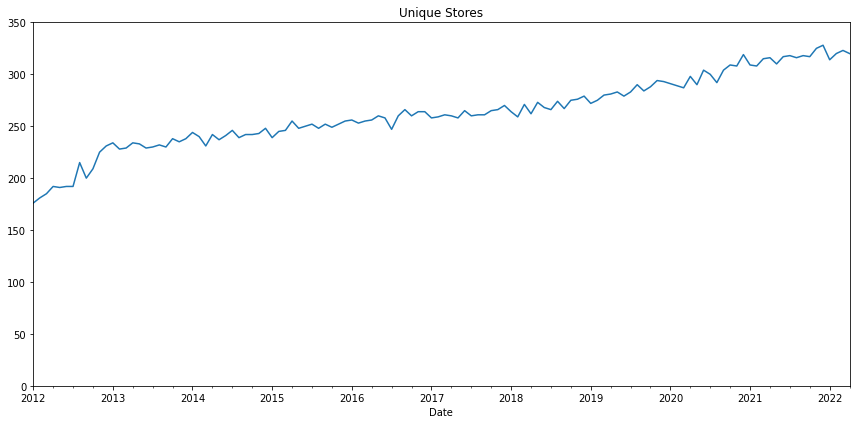

In [569]:
#total unique nonhyvee stores in collegetowns

totalStores = c_transactions[~c_transactions['StoreNumber'].isin(store_HyVeeC['StoreNumber'])].groupby(
    ['StoreNumber', pd.Grouper(key='Date', freq='M')])['Sale'].sum()
totalStores = totalStores.reset_index('Date').pivot_table(index='StoreNumber', columns='Date', aggfunc=np.sum)
totalStores.columns = totalStores.columns.droplevel(0)

f,ax = plt.subplots(figsize = (12,6))
totalStores.count().plot()
ax.set_title('Unique Stores')
ax.set_ylim(bottom=0, top=350)
f.tight_layout()

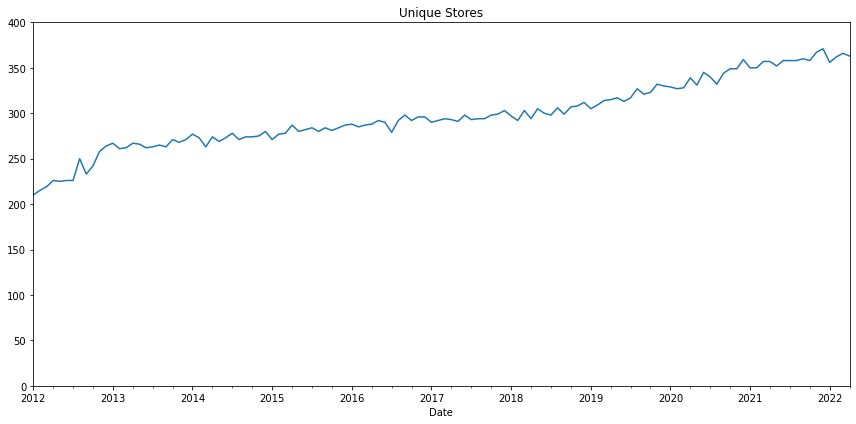

In [132]:
#total unique nonhyvee stores in collegetowns
totalStores = c_transactions.copy()
totalStores['Hyvee?'] = np.where(totalStores['StoreName'].str.contains('Hy-Vee'),1,0)
totalStores = totalStores.groupby(['StoreNumber','Hyvee?',pd.Grouper(key='Date', freq='M')]).agg({'Sale':'sum'})

totalStores = totalStores.reset_index('Date').pivot_table(index='StoreNumber', columns='Date', aggfunc=np.sum)
totalStores.columns = totalStores.columns.droplevel(0)

f,ax = plt.subplots(figsize = (12,6))
totalStores.count().plot()
ax.set_title('Unique Stores')
ax.set_ylim(bottom=0, top=400)
f.tight_layout()



In [134]:
totalStores

Date         2012-01-31  2012-02-29  2012-03-31  2012-04-30  2012-05-31  \
StoreNumber                                                               
2106           75433.57    85486.43    99211.55    85410.04    87713.55   
2130           61562.72    95402.20   117627.40    56680.22    82798.50   
2190          589587.46   614049.19   710102.08   690440.05   672526.58   
2201                NaN         NaN         NaN         NaN         NaN   
2248           29452.48    43927.83    33045.17    43864.41    40615.61   
...                 ...         ...         ...         ...         ...   
9919                NaN         NaN         NaN         NaN         NaN   
9922                NaN         NaN         NaN         NaN         NaN   
9925                NaN         NaN         NaN         NaN         NaN   
9929                NaN         NaN         NaN         NaN         NaN   
9932                NaN         NaN         NaN         NaN         NaN   

Date         2012-06-30  2012-07-31  2012-08-31  2012-09-30  2012-10-31  ...  \
StoreNumber                                                              ...   
2106           74340.11    68239.62    96736.21    67043.31    87862.29  ...   
2130           70632.17    89728.38    91917.55    74604.04    92012.55  ...   
2190          601463.27   662268.79   754194.53   490950.56   725085.72  ...   
2201                NaN         NaN         NaN         NaN         NaN  ...   
2248           42633.70    45062.89    45945.38    33436.93    66940.71  ...   
...                 ...         ...         ...         ...         ...  ...   
9919                NaN         NaN         NaN         NaN         NaN  ...   
9922                NaN         NaN         NaN         NaN         NaN  ...   
9925                NaN         NaN         NaN         NaN         NaN  ...   
9929                NaN         NaN         NaN         NaN         NaN  ...   
9932                NaN         NaN         NaN         NaN         NaN  ...   

Date         2021-07-31  2021-08-31  2021-09-30  2021-10-31  2021-11-30  \
StoreNumber                                                               
2106           88697.41    82818.80   103932.92    70060.83    88929.31   
2130          134159.85    60144.66   122697.36   107668.53    96996.32   
2190          194602.66   205893.48   211258.80   206957.53   252891.28   
2201                NaN         NaN         NaN     1550.99     3400.89   
2248           60147.43    39269.30    60226.32    41356.80    61225.56   
...                 ...         ...         ...         ...         ...   
9919                NaN         NaN         NaN         NaN         NaN   
9922                NaN         NaN         NaN         NaN         NaN   
9925                NaN         NaN         NaN         NaN         NaN   
9929                NaN         NaN         NaN         NaN         NaN   
9932                NaN         NaN         NaN         NaN         NaN   

Date         2021-12-31  2022-01-31  2022-02-28  2022-03-31  2022-04-30  
StoreNumber                                                              
2106           83806.15    55756.46    75645.72    85082.22    76277.25  
2130          124793.77    92926.88   126479.91   142286.80   114782.21  
2190          256807.22   173783.16   203788.35   206641.30   201056.77  
2201            4818.92    26895.84    17355.56     9207.57    97980.94  
2248           74401.89    33860.99    48074.64    35888.20    45776.74  
...                 ...         ...         ...         ...         ...  
9919                NaN         NaN         NaN         NaN         NaN  
9922                NaN         NaN         NaN         NaN         NaN  
9925                NaN         NaN         NaN         NaN         NaN  
9929                NaN         NaN         NaN         NaN         NaN  
9932                NaN         NaN         NaN         NaN         NaN  

[588 rows x 124 columns]

In [494]:
2.866226e+08 + 1.415009e+08	

428123500.0

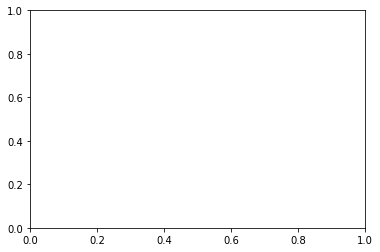

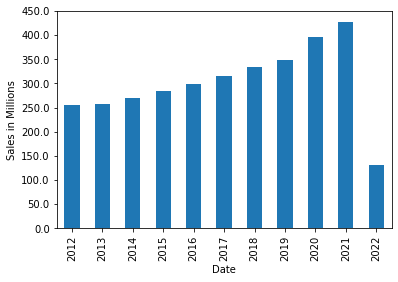

In [373]:
#overall sales
overall_sales = transactionsdf[['Date', "Sale"]]
overall_sales['Date'] = pd.to_datetime(overall_sales['Date'], 
                                        infer_datetime_format=True)
overall_sales['Date'] = overall_sales['Date'].dt.year

overall_sales = overall_sales.reset_index(drop=True)
fig,ax = plt.subplots()
ax = overall_sales.groupby('Date').agg({'Sale':'sum'}).plot.bar(legend = None)
plt.ylabel('Sales in Millions')
plt.yticks(ticks=plt.yticks()[0], labels=plt.yticks()[0].astype(int))

ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x)/1000000, ',')))
plt.show()

# sales for hyvee and non hyvee in all of iowa

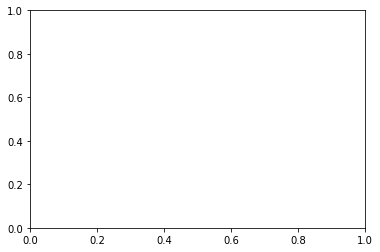

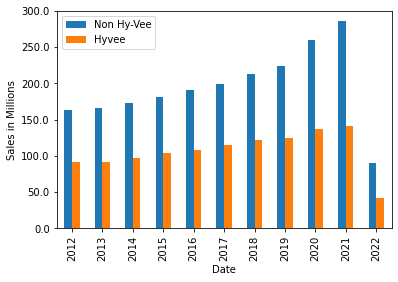

In [378]:
#overall sales
overall_sales = transactionsdf[['Date', 'StoreNumber',"Sale"]]

overall_sales = overall_sales.merge(storesdf, on = "StoreNumber")
overall_sales['Hyvee?'] = np.where(overall_sales['StoreName'].str.contains('Hy-Vee'),1,0)
overall_sales['Date'] = pd.to_datetime(overall_sales['Date'], 
                                        infer_datetime_format=True)
overall_sales['Date'] = overall_sales['Date'].dt.year
overall_sales = overall_sales.reset_index(drop=True)

fig,ax = plt.subplots()
ax = overall_sales.groupby(['Date','Hyvee?']).agg({'Sale':'sum'}).unstack().plot.bar()
plt.ylabel('Sales in Millions')
plt.ylim(0,300000000)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x)/1000000, ',')))
plt.legend(labels = ['Non Hy-Vee', 'Hyvee'])
plt.show()

# market share for all of iowa

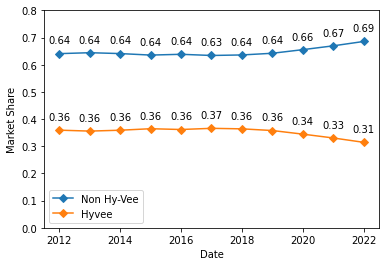

In [414]:
#overall sales
overall_sales = transactionsdf[['Date', 'StoreNumber',"Sale"]]

overall_sales = overall_sales.merge(storesdf, on = "StoreNumber")
overall_sales['Hyvee?'] = np.where(overall_sales['StoreName'].str.contains('Hy-Vee'),1,0)
overall_sales['Date'] = pd.to_datetime(overall_sales['Date'], 
                                        infer_datetime_format=True)
overall_sales['Date'] = overall_sales['Date'].dt.year
overall_sales = overall_sales.reset_index(drop=True)
overall_sales =  overall_sales.groupby(['Date','Hyvee?']).agg({'Sale':'sum'})

overall_sales['market share'] = 0

for i in range(0,22,2):
    overall_sales['market share'].iloc[i] =  overall_sales['Sale'].iloc[i] \
    / (overall_sales['Sale'].iloc[i] + overall_sales['Sale'].iloc[i + 1])
    overall_sales['market share'].iloc[i + 1] = overall_sales['Sale'].iloc[i\
    + 1] / (overall_sales['Sale'].iloc[i] + overall_sales['Sale'].iloc[i + 1])

fig,ax = plt.subplots()

overall_sales.unstack().plot(y = 'market share',kind='line', ax=ax, marker= 'D')

plt.ylabel('Market Share')
plt.ylim(0,0.8)
# ax.get_yaxis().set_major_formatter(
#     matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x)/1000000, ',')))
plt.legend(labels = ['Non Hy-Vee', 'Hyvee'], loc = 'lower left')

xs = list(overall_sales.unstack().index)
ys = list(overall_sales.unstack()['market share',0])
zs = list(overall_sales.unstack()['market share',1])

for x,y in zip(xs,ys):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')

for x,z in zip(xs,zs):

    label = "{:.2f}".format(z)

    plt.annotate(label, # this is the text
                 (x,z), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')
    


plt.show()


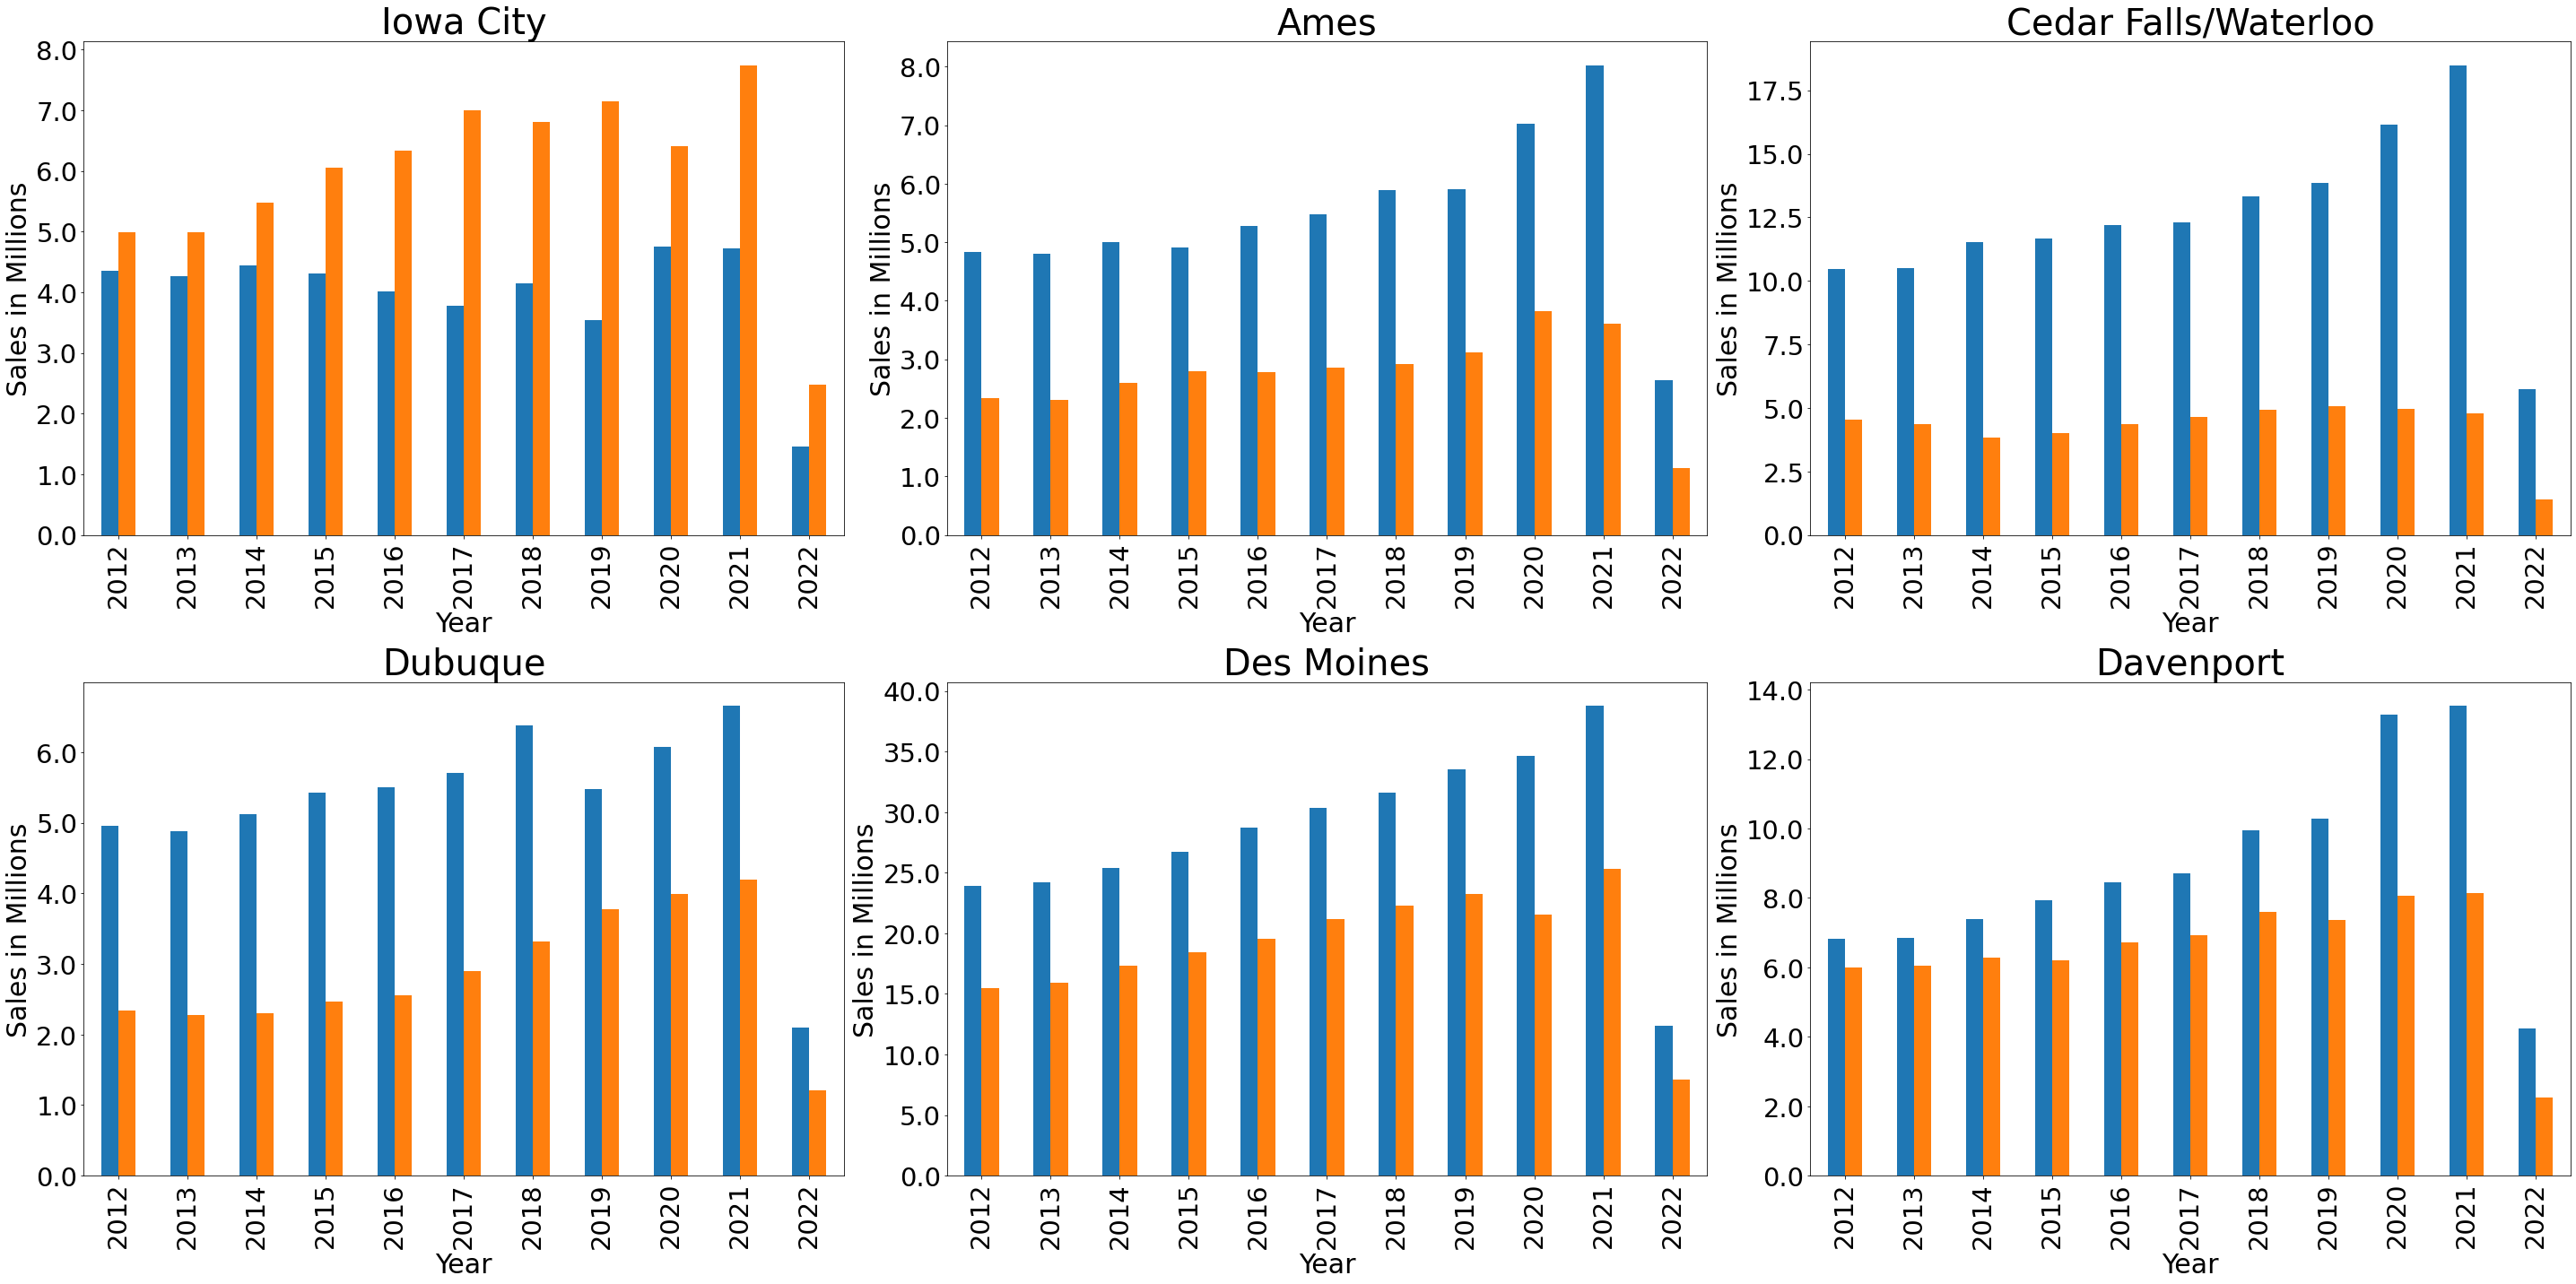

In [545]:
collegetown_sales = transactionsdf[['Date', 'StoreNumber', "Sale"]]
collegetown_sales = pd.merge(collegetown_sales, storesdf, on= 'StoreNumber')
# collegetown_sales['ZipCode']=collegetown_sales['ZipCode'].str.replace('-','')
collegetown_sales.loc[:, 'ZipCode'] = collegetown_sales['ZipCode'].astype(int)
collegetown_sales = collegetown_sales[collegetown_sales["ZipCode"].isin(college_zipcodes)]
collegetown_sales['Hyvee?'] = np.where(collegetown_sales['StoreName'].str.contains('Hy-Vee'),1,0)
collegetown_sales['Date'] = pd.to_datetime(collegetown_sales['Date'], 
                                        infer_datetime_format=True)
collegetown_sales['Date'] = collegetown_sales['Date'].dt.year
# collegetown_sales['Sale']=collegetown_sales['Sale'].str.replace('.','')
# collegetown_sales['Sale']=collegetown_sales['Sale'].str.replace(',','')
collegetown_sales['Sale']=collegetown_sales['Sale'].fillna(0)

collegetown_sales["Sale"] = collegetown_sales["Sale"].astype(int)
collegetown_sales.loc[collegetown_sales.ZipCode.isin(des_moines_zips), 'City'] = 'Des Moines'
collegetown_sales.loc[collegetown_sales.ZipCode.isin(iowa_city_zips), 'City'] = 'Iowa City'
collegetown_sales.loc[collegetown_sales.ZipCode.isin(ames_zips), 'City'] = 'Ames'
collegetown_sales.loc[collegetown_sales.ZipCode.isin(cedar_waterloo_zips), 'City'] = 'Cedar Falls/Waterloo'
collegetown_sales.loc[collegetown_sales.ZipCode.isin(dubuque_zips), 'City'] = 'Dubuque'
collegetown_sales.loc[collegetown_sales.ZipCode.isin(davenport_zips), 'City'] = 'Davenport'

fig, axs = plt.subplots(nrows= 2, ncols=3, figsize=(40,20))
# axs = np.delete(axs, 7)
ax = axs.ravel()

for i, zip_code, town in zip(range(0,6), [iowa_city_zips, ames_zips,
                            cedar_waterloo_zips,dubuque_zips,
                            des_moines_zc, davenport_zips], college_towns):
    plt.rcParams.update({'font.size': 22}) # must set in top
    groupby = collegetown_sales[collegetown_sales["ZipCode"].isin(zip_code)]
    groupby = groupby.groupby(['Date','Hyvee?']).agg({'Sale':'sum'})
    groupby.unstack().plot(y = 'Sale',kind='bar', ax = ax[i],title = town,xlabel = 'Date', ylabel = 'Sales in Millions', fontsize = 29, legend = None)
    ax[i].set_ylabel('Sales in Millions',fontdict={'fontsize':30})
    ax[i].set_xlabel('Year',fontdict={'fontsize':30} )
    ax[i].set_title(town, fontsize = 40)
    ax[i].get_yaxis().set_major_formatter(\
                                       matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x)/1000000, ',')))
plt.tight_layout()
plt.show()


In [516]:
#market share for hyvee and non hyvee in each county
collegetown_sales = transactionsdf[['Date', 'StoreNumber', "Sale"]]
collegetown_sales = pd.merge(collegetown_sales, storesdf, on= 'StoreNumber')
# collegetown_sales['ZipCode']=collegetown_sales['ZipCode'].str.replace('-','')
collegetown_sales.loc[:, 'ZipCode'] = collegetown_sales['ZipCode'].astype(int)
collegetown_sales = collegetown_sales[collegetown_sales["ZipCode"].isin(college_zipcodes)]
collegetown_sales['Hyvee?'] = np.where(collegetown_sales['StoreName'].str.contains('Hy-Vee'),1,0)
collegetown_sales['Date'] = pd.to_datetime(collegetown_sales['Date'], 
                                        infer_datetime_format=True)
collegetown_sales['Date'] = collegetown_sales['Date'].dt.year
# collegetown_sales['Sale']=collegetown_sales['Sale'].str.replace('.','')
# collegetown_sales['Sale']=collegetown_sales['Sale'].str.replace(',','')
collegetown_sales['Sale']=collegetown_sales['Sale'].fillna(0)

collegetown_sales["Sale"] = collegetown_sales["Sale"].astype(int)
collegetown_sales.loc[collegetown_sales.ZipCode.isin(des_moines_zips), 'City'] = 'Des Moines'
collegetown_sales.loc[collegetown_sales.ZipCode.isin(iowa_city_zips), 'City'] = 'Iowa City'
collegetown_sales.loc[collegetown_sales.ZipCode.isin(ames_zips), 'City'] = 'Ames'
collegetown_sales.loc[collegetown_sales.ZipCode.isin(cedar_waterloo_zips), 'City'] = 'Cedar Falls/Waterloo'
collegetown_sales.loc[collegetown_sales.ZipCode.isin(dubuque_zips), 'City'] = 'Dubuque'
collegetown_sales.loc[collegetown_sales.ZipCode.isin(davenport_zips), 'City'] = 'Davenport'

collegetown_sales = collegetown_sales.groupby(['Date','City','Hyvee?']).agg({'Sale' : 'sum'})

collegetown_sales['market share'] = 0

for i in range(0,132,2):
    collegetown_sales['market share'].iloc[i] =  collegetown_sales['Sale'].iloc[i] \
    / (collegetown_sales['Sale'].iloc[i] + collegetown_sales['Sale'].iloc[i + 1])
    collegetown_sales['market share'].iloc[i + 1] = collegetown_sales['Sale'].iloc[i\
    + 1] / (collegetown_sales['Sale'].iloc[i] + collegetown_sales['Sale'].iloc[i + 1])
    

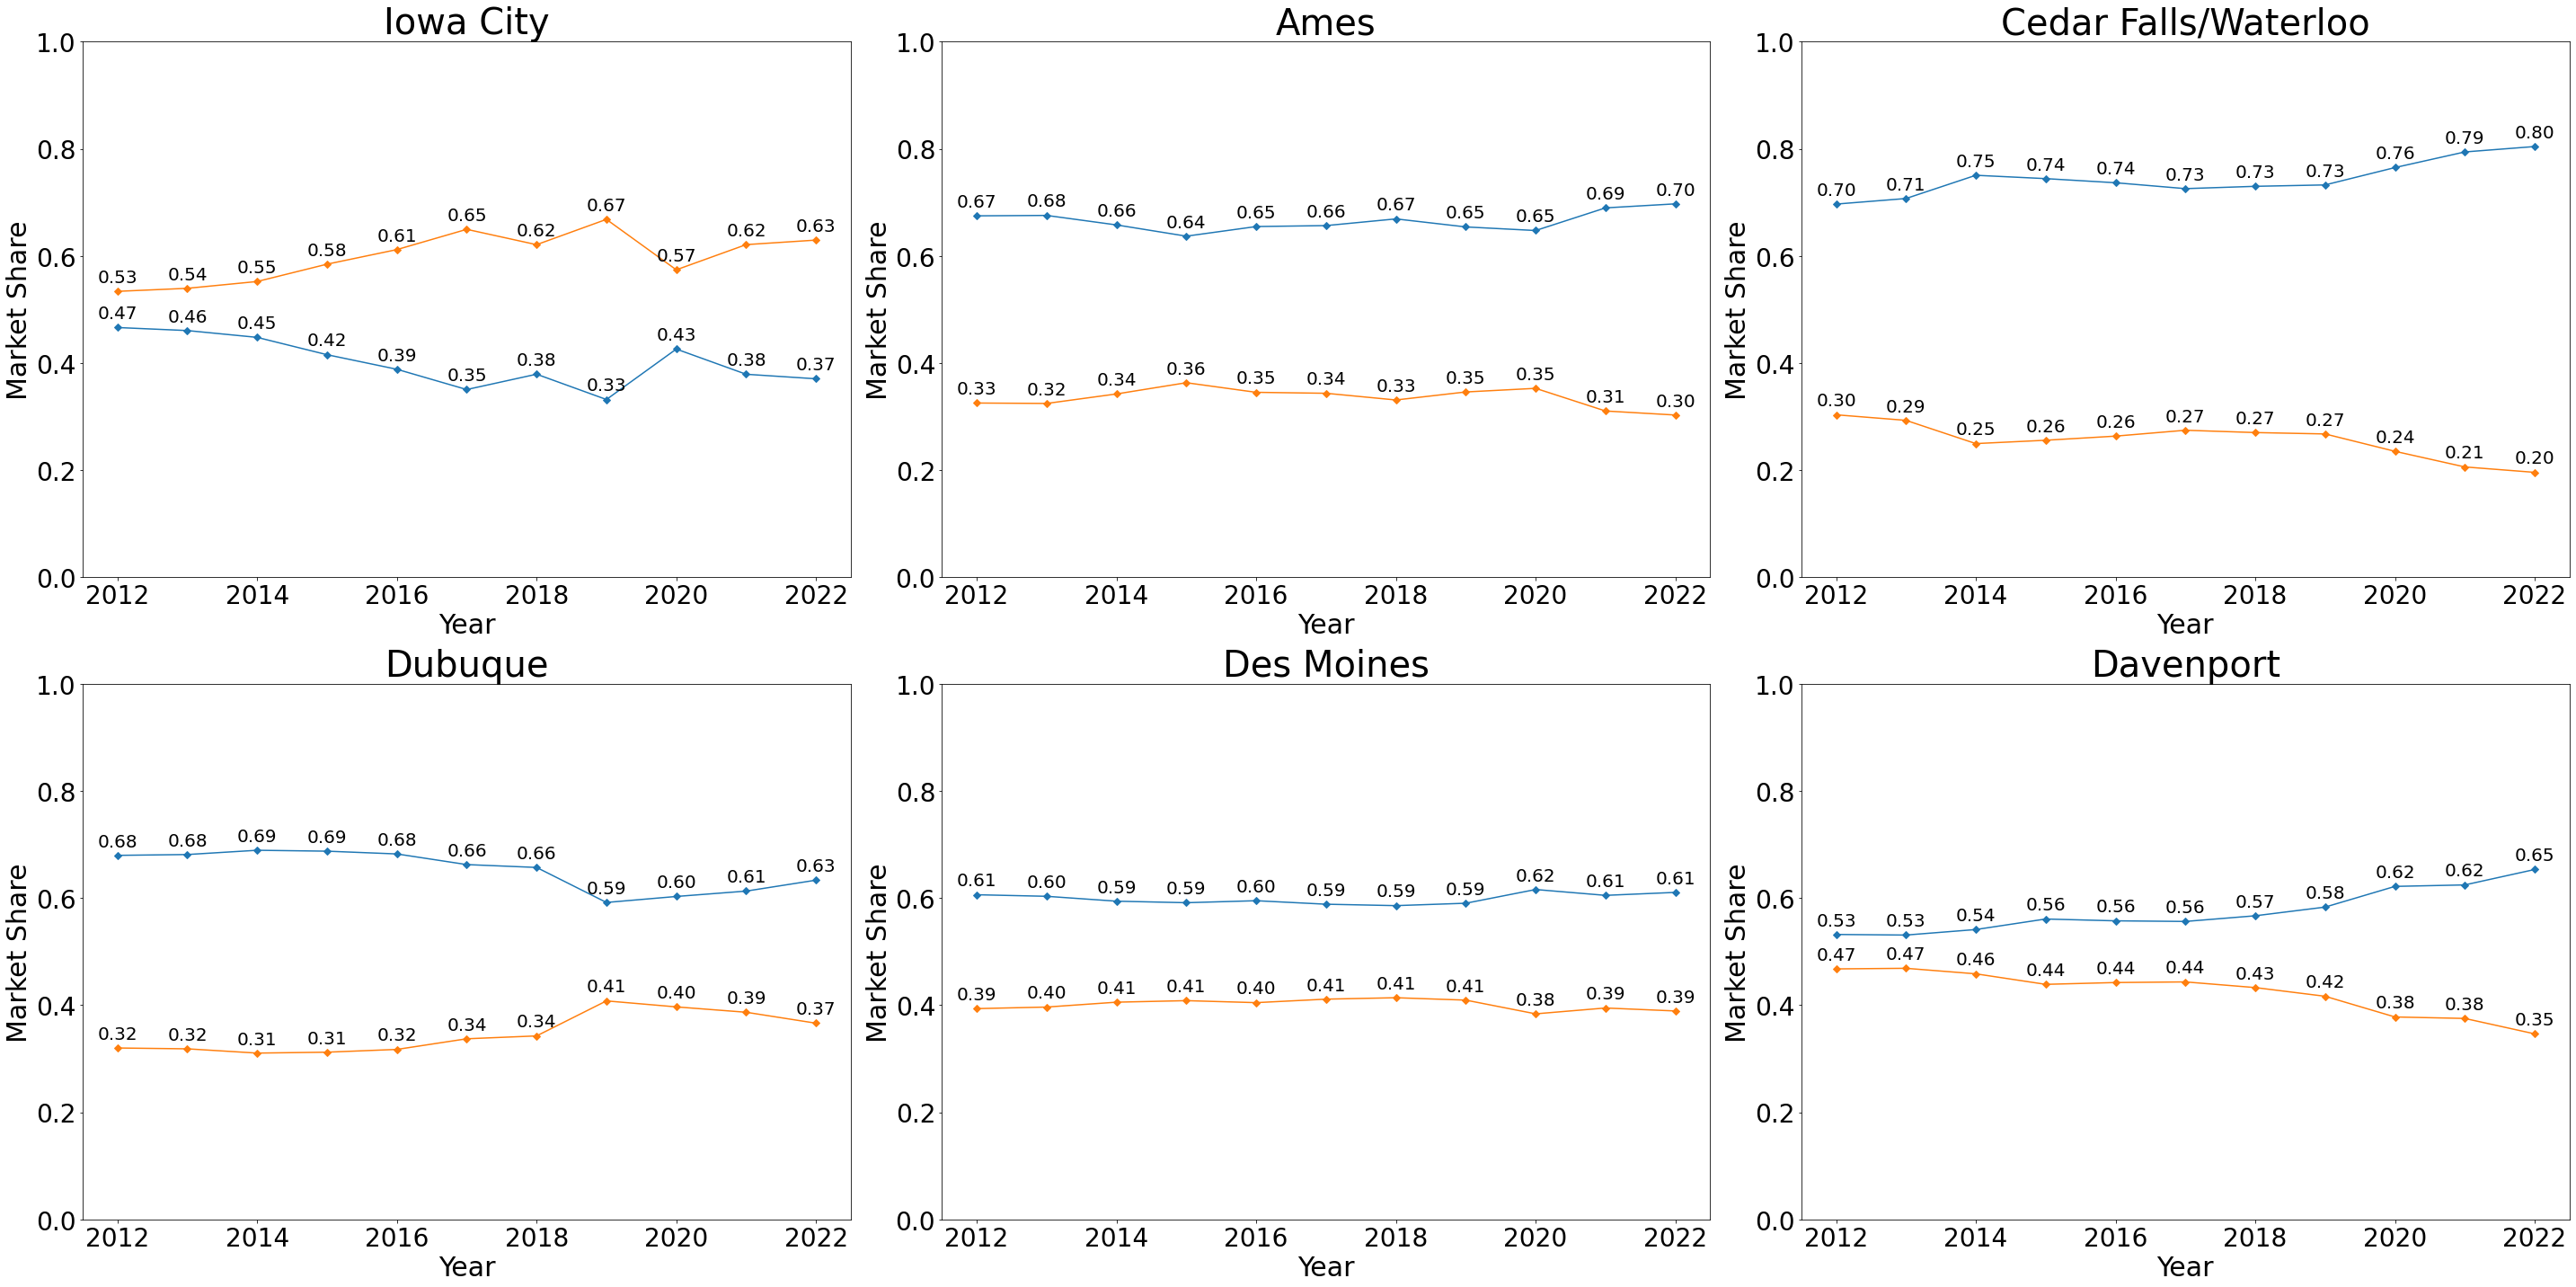

In [542]:
ab = collegetown_sales.reset_index('City')
ab

fig, axs = plt.subplots(nrows= 2, ncols=3, figsize=(40,20))
# axs = np.delete(axs, 7)
ax = axs.ravel()

plt.rcParams.update({'font.size': 22})

for i,town in zip(range(0,6),college_towns):
    df = ab[ab['City'] == town]
    xs = list(df.unstack().index)
    ys = list(df.unstack()['market share', 0])
    zs = list(df.unstack()['market share',1])
    plt.rcParams.update({'font.size': 22})

    df.unstack().plot(y = 'market share', marker = "D",kind='line', ax=ax[i], title=town, legend = None, fontsize = 28)
    for x,y in zip(xs,ys):

        label = "{:.2f}".format(y)

        ax[i].annotate(label, # this is the text
                 (x,y),
                       fontsize = 20,# these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')
    for x,z in zip(xs,zs):

        label = "{:.2f}".format(z)

        ax[i].annotate(label,# this is the text
                 (x,z),
                    fontsize = 20,# these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')
    ax[i].set_xlabel('Year',fontdict={'fontsize':30} )
    ax[i].set_ylabel('Market Share',fontdict={'fontsize':30})
    ax[i].set_title(town, fontsize = 40)
    ax[i].set_ylim(bottom=0, top=1.0)
plt.tight_layout()
plt.show()



In [530]:
df = ab[ab['City'] == town]
df.unstack()['market share', 0]

Date
2012    0.532162
2013    0.531039
2014    0.541349
2015    0.561015
2016    0.557627
2017    0.556453
2018    0.567043
2019    0.583264
2020    0.621909
2021    0.624679
2022    0.653460
Name: (market share, 0), dtype: float64

In [297]:
store_HyVee = college_storesdf.copy()
store_HyVee['HyVee_control'] = np.where(store_HyVee['StoreName'].str.contains('Hy-Vee'),1,0)

store_HyVee = store_HyVee.loc[store_HyVee['HyVee_control'] == 1].reset_index()
store_HyVeeC= store_HyVee.drop(columns = ['HyVee_control'])
store_HyVeeC = store_HyVeeC.reset_index(drop = True)
store_HyVeeC.groupby(by = ['ZipCode']).count()
store_HyVeeC['StoreType'] = 'General Store'
store_HyVeeC.loc[store_HyVeeC.StoreName.str.contains('Food'), 'StoreType'] = 'Food Store'
store_HyVeeC.loc[store_HyVeeC.StoreName.str.contains('Wine'), 'StoreType'] = 'Wine & Spirits'
store_HyVeeC.loc[store_HyVeeC.StoreName.str.contains('Drug'), 'StoreType'] = 'Drugstore'


Text(0, 0.5, 'Count of Stores')

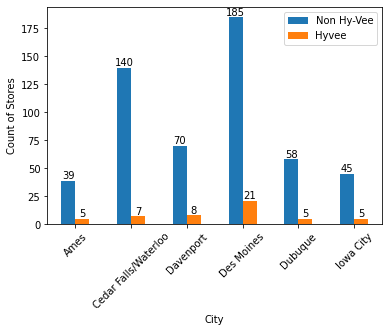

In [510]:
# Look at HyVee store vs non hyvee distribution by county.
store_distribution = college_storesdf.copy()
store_distribution.loc[store_distribution.ZipCode.isin(des_moines_zips), 'City'] = 'Des Moines'
store_distribution.loc[store_distribution.ZipCode.isin(iowa_city_zips), 'City'] = 'Iowa City'
store_distribution.loc[store_distribution.ZipCode.isin(ames_zips), 'City'] = 'Ames'
store_distribution.loc[store_distribution.ZipCode.isin(cedar_waterloo_zips), 'City'] = 'Cedar Falls/Waterloo'
store_distribution.loc[store_distribution.ZipCode.isin(dubuque_zips), 'City'] = 'Dubuque'
store_distribution.loc[store_distribution.ZipCode.isin(davenport_zips), 'City'] = 'Davenport'
store_distribution['HyVee_control'] = np.where(store_distribution['StoreName'].str.contains('Hy-Vee'),1,0)

b = store_distribution.groupby(['City','HyVee_contr\
ol']).agg({'StoreNumber':'count'}).sort_values(by = 'StoreNumber')

ax = b.unstack().plot(kind='bar')
for container in ax.containers:
    ax.bar_label(container)
plt.legend(labels = ['Non Hy-Vee', 'Hyvee'])
plt.xticks(rotation = 45)
plt.ylabel("Count of Stores")


In [469]:
collegetown_sales = transactionsdf[['Date', 'StoreNumber', "Sale"]]
collegetown_sales = pd.merge(collegetown_sales, storesdf, on= 'StoreNumber')
# collegetown_sales['ZipCode']=collegetown_sales['ZipCode'].str.replace('-','')
collegetown_sales.loc[:, 'ZipCode'] = collegetown_sales['ZipCode'].astype(int)
collegetown_sales = collegetown_sales[collegetown_sales["ZipCode"].isin(college_zipcodes)]
collegetown_sales['Hyvee?'] = np.where(collegetown_sales['StoreName'].str.contains('Hy-Vee'),1,0)
collegetown_sales['Date'] = pd.to_datetime(collegetown_sales['Date'], 
                                        infer_datetime_format=True)
collegetown_sales['Date'] = collegetown_sales['Date'].dt.year
# collegetown_sales['Sale']=collegetown_sales['Sale'].str.replace('.','')
# collegetown_sales['Sale']=collegetown_sales['Sale'].str.replace(',','')
collegetown_sales['Sale']=collegetown_sales['Sale'].fillna(0)

collegetown_sales["Sale"] = collegetown_sales["Sale"].astype(int)



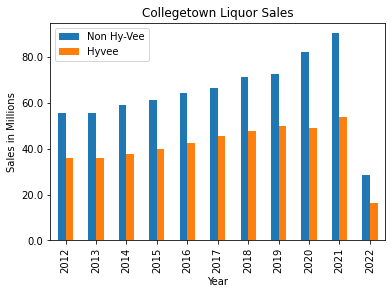

In [471]:


a = collegetown_sales.groupby(['Date','Hyvee?']).agg({'Sale' : 'sum'})

ax = a.unstack().plot(kind='bar')
plt.ylabel('Sales in Millions')
plt.xlabel('Year')
plt.title("Collegetown Liquor Sales")
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x)/1000000, ',')))
plt.legend(labels = ['Non Hy-Vee', 'Hyvee'])


In [495]:
(90205044 + 53777247)/428123500.0

0.336310179188949

In [100]:
a.loc[2012, 0][1] = a.loc[2012, 0][1].astype('float32')
# a.loc[2012, 0][1] = a.loc[2012, 0][0] / (a.loc[2012, 0][0] + a.loc[2012, 1][0])
type(a.loc[2012, 0][1])


numpy.float64

0

In [102]:
a.loc[2012, 0][0] / (a.loc[2012, 0][0] + a.loc[2012, 1][0])




0.6076762236445051

In [112]:
a.loc[2012, 0][0] /(a.loc[2012, 0][0] + a.loc[2012, 1][0])

0.6076762236445051

In [139]:
for i in range(0,22,2):
    print(i)

0
2
4
6
8
10
12
14
16
18
20


In [472]:
a['market share'] = 0
for i in range(0,22,2):
    a['market share'].iloc[i] =  a['Sale'].iloc[i] / (a['Sale'].iloc[i] + a['Sale'].iloc[i + 1])
    a['market share'].iloc[i + 1] = a['Sale'].iloc[i + 1] / (a['Sale'].iloc[i] + a['Sale'].iloc[i + 1])
    
a['market share'] = a['market share'].round(decimals = 2)
a

Sale  market share
Date Hyvee?                        
2012 0       55311131          0.61
     1       35707895          0.39
2013 0       55522060          0.61
     1       35897323          0.39
2014 0       58899920          0.61
     1       37832254          0.39
2015 0       60973402          0.60
     1       40002652          0.40
2016 0       64143710          0.60
     1       42262036          0.40
2017 0       66302462          0.59
     1       45564234          0.41
2018 0       71277213          0.60
     1       47877478          0.40
2019 0       72660658          0.59
     1       49743726          0.41
2020 0       81867868          0.63
     1       48821963          0.37
2021 0       90205044          0.63
     1       53777247          0.37
2022 0       28555165          0.64
     1       16383374          0.36

In [478]:
a.unstack()['market share']

Hyvee?     0     1
Date              
2012    0.61  0.39
2013    0.61  0.39
2014    0.61  0.39
2015    0.60  0.40
2016    0.60  0.40
2017    0.59  0.41
2018    0.60  0.40
2019    0.59  0.41
2020    0.63  0.37
2021    0.63  0.37
2022    0.64  0.36

(0.0, 1.0)

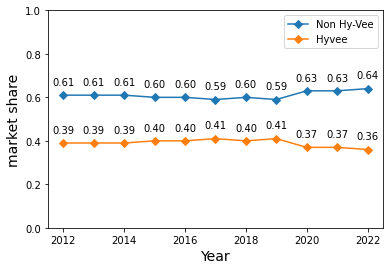

In [484]:

a.unstack().plot(y = 'market share', kind='line',marker= 'D')

xs = list(a.unstack().index)
ys = list(a.unstack()['market share',0])
zs = list(a.unstack()['market share',1])

for x,y in zip(xs,ys):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')
for x,z in zip(xs,zs):

    label = "{:.2f}".format(z)

    plt.annotate(label, # this is the text
                 (x,z), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')

plt.ylabel('market share', fontsize = 14)
plt.xlabel('Year', fontsize = 14)
plt.legend(labels = ['Non Hy-Vee', 'Hyvee'])
plt.ylim(bottom = 0, top = 1.0)


In [136]:
c_transactions

Date  StoreNumber  Category  VendorNumber  ItemNumber  \
38411    2012-01-03         2625   1031200           260       41715   
38412    2012-01-03         2625   1031100           300       36908   
38413    2012-01-03         2625   1011500           260       27025   
38414    2012-01-03         2625   1031080            55       37938   
38415    2012-01-03         2625   1062200            35       43036   
...             ...          ...       ...           ...         ...   
23774139 2022-04-29         6303   1022200           395       89206   
23774140 2022-04-29         6303   1041100            65       30236   
23774141 2022-04-29         6303   1041100           297       29994   
23774142 2022-04-29         6303   1052100           420       48106   
23774143 2022-04-29         6303   1052100           420       48123   

          BottlesSold  Volume(Gallons)    Sale  \
38411               2              NaN   23.12   
38412              12              NaN  134.28   
38413               0              NaN   22.26   
38414               6              NaN   63.90   
38415               4              NaN   45.20   
...               ...              ...     ...   
23774139            3              NaN   71.91   
23774140            3              NaN   22.50   
23774141            3              NaN    8.97   
23774142           12              NaN  413.88   
23774143            1              NaN   89.99   

                                             StoreName        City  ZipCode  \
38411             Hy-Vee Wine & Spirits #2 / Davenport   Davenport    52804   
38412             Hy-Vee Wine & Spirits #2 / Davenport   Davenport    52804   
38413             Hy-Vee Wine & Spirits #2 / Davenport   Davenport    52804   
38414             Hy-Vee Wine & Spirits #2 / Davenport   Davenport    52804   
38415             Hy-Vee Wine & Spirits #2 / Davenport   Davenport    52804   
...                                                ...         ...      ...   
23774139  World Liquor & Tobacco + Vapors / Des Moines  Des Moines    50320   
23774140  World Liquor & Tobacco + Vapors / Des Moines  Des Moines    50320   
23774141  World Liquor & Tobacco + Vapors / Des Moines  Des Moines    50320   
23774142  World Liquor & Tobacco + Vapors / Des Moines  Des Moines    50320   
23774143  World Liquor & Tobacco + Vapors / Des Moines  Des Moines    50320   

          CountyNumber County  
38411             82.0  SCOTT  
38412             82.0  SCOTT  
38413             82.0  SCOTT  
38414             82.0  SCOTT  
38415             82.0  SCOTT  
...                ...    ...  
23774139          77.0   POLK  
23774140          77.0   POLK  
23774141          77.0   POLK  
23774142          77.0   POLK  
23774143          77.0   POLK  

[6898889 rows x 13 columns]

In [ ]:
totalStores = sales.groupby(['StoreNumber', pd.Grouper(key='Date', freq='M')])['Sale'].sum()
totalSales = totalStores.reset_index().groupby('Date').agg(Sale=('Sale','sum'))

totalStores = totalStores.reset_index().groupby('Date').agg(Stores=('StoreNumber', 'count'))
avg_sales_per_store = totalSales.Sale/totalStores.Stores
f,ax = plt.subplots(figsize = (12,6))
pd.DataFrame(avg_sales_per_store,index=totalStores.index).plot(ax=ax, legend=None)
ax.set_title('Average Sales per Store')
f.tight_layout()

In [159]:
totalStores.reset_index('Hyvee?')

Hyvee?  Stores
Date                      
2012-01-31       0     176
2012-02-29       0     181
2012-03-31       0     185
2012-04-30       0     192
2012-05-31       0     191
...            ...     ...
2021-12-31       1      43
2022-01-31       1      42
2022-02-28       1      42
2022-03-31       1      43
2022-04-30       1      43

[248 rows x 2 columns]

In [210]:
c_transactions['Hyvee?'] = np.where(c_transactions['StoreName'].str.contains('Hy-Vee'),1,0)
totalStores = c_transactions[c_transactions["ZipCode"].isin(iowa_city_zips)]

totalStores = totalStores.groupby(['Hyvee?','StoreNumber', pd.Grouper(key='Date', freq='M')])['Sale'].sum()
totalStores

Hyvee?  StoreNumber  Date      
0       2285         2012-01-31    33791.00
                     2012-02-29    41362.68
                     2012-03-31    29308.80
                     2012-04-30    47012.46
                     2012-05-31    35749.05
                                     ...   
1       2622         2022-01-31    59225.31
                     2022-02-28    72455.85
                     2022-03-31    92936.82
                     2022-04-30    59131.38
        6259         2022-03-31     1191.00
Name: Sale, Length: 3181, dtype: float64

In [ ]:
to

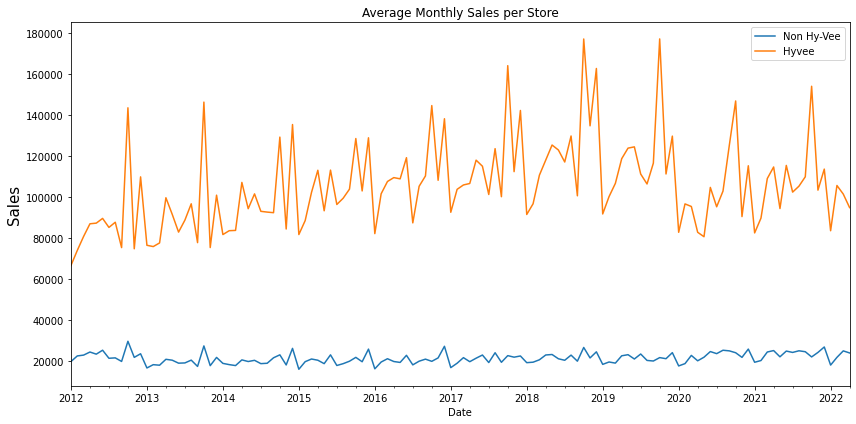

In [579]:
#average sales per hyvee/nonhyvee store
totalStores = c_transactions.groupby(['Hyvee?','StoreNumber', pd.Grouper(key='Date', freq='M')])['Sale'].sum()
totalSales = totalStores.reset_index().groupby(['Date', 'Hyvee?']).agg(Sale=('Sale','sum'))
totalStores = totalStores.reset_index().groupby(['Date', 'Hyvee?']).agg(Stores=('StoreNumber', 'count'))

avg_sales_per_store = totalSales.Sale/totalStores.Stores

f,ax = plt.subplots(figsize = (12,6))
pd.DataFrame(avg_sales_per_store,index=totalStores.index).unstack().plot(ax=ax, legend=None)
ax.set_title('Average Monthly Sales per Store')
ax.set_ylabel('Sales',fontsize = 15)
ax.legend(labels = ['Non Hy-Vee', 'Hyvee'])
f.tight_layout()

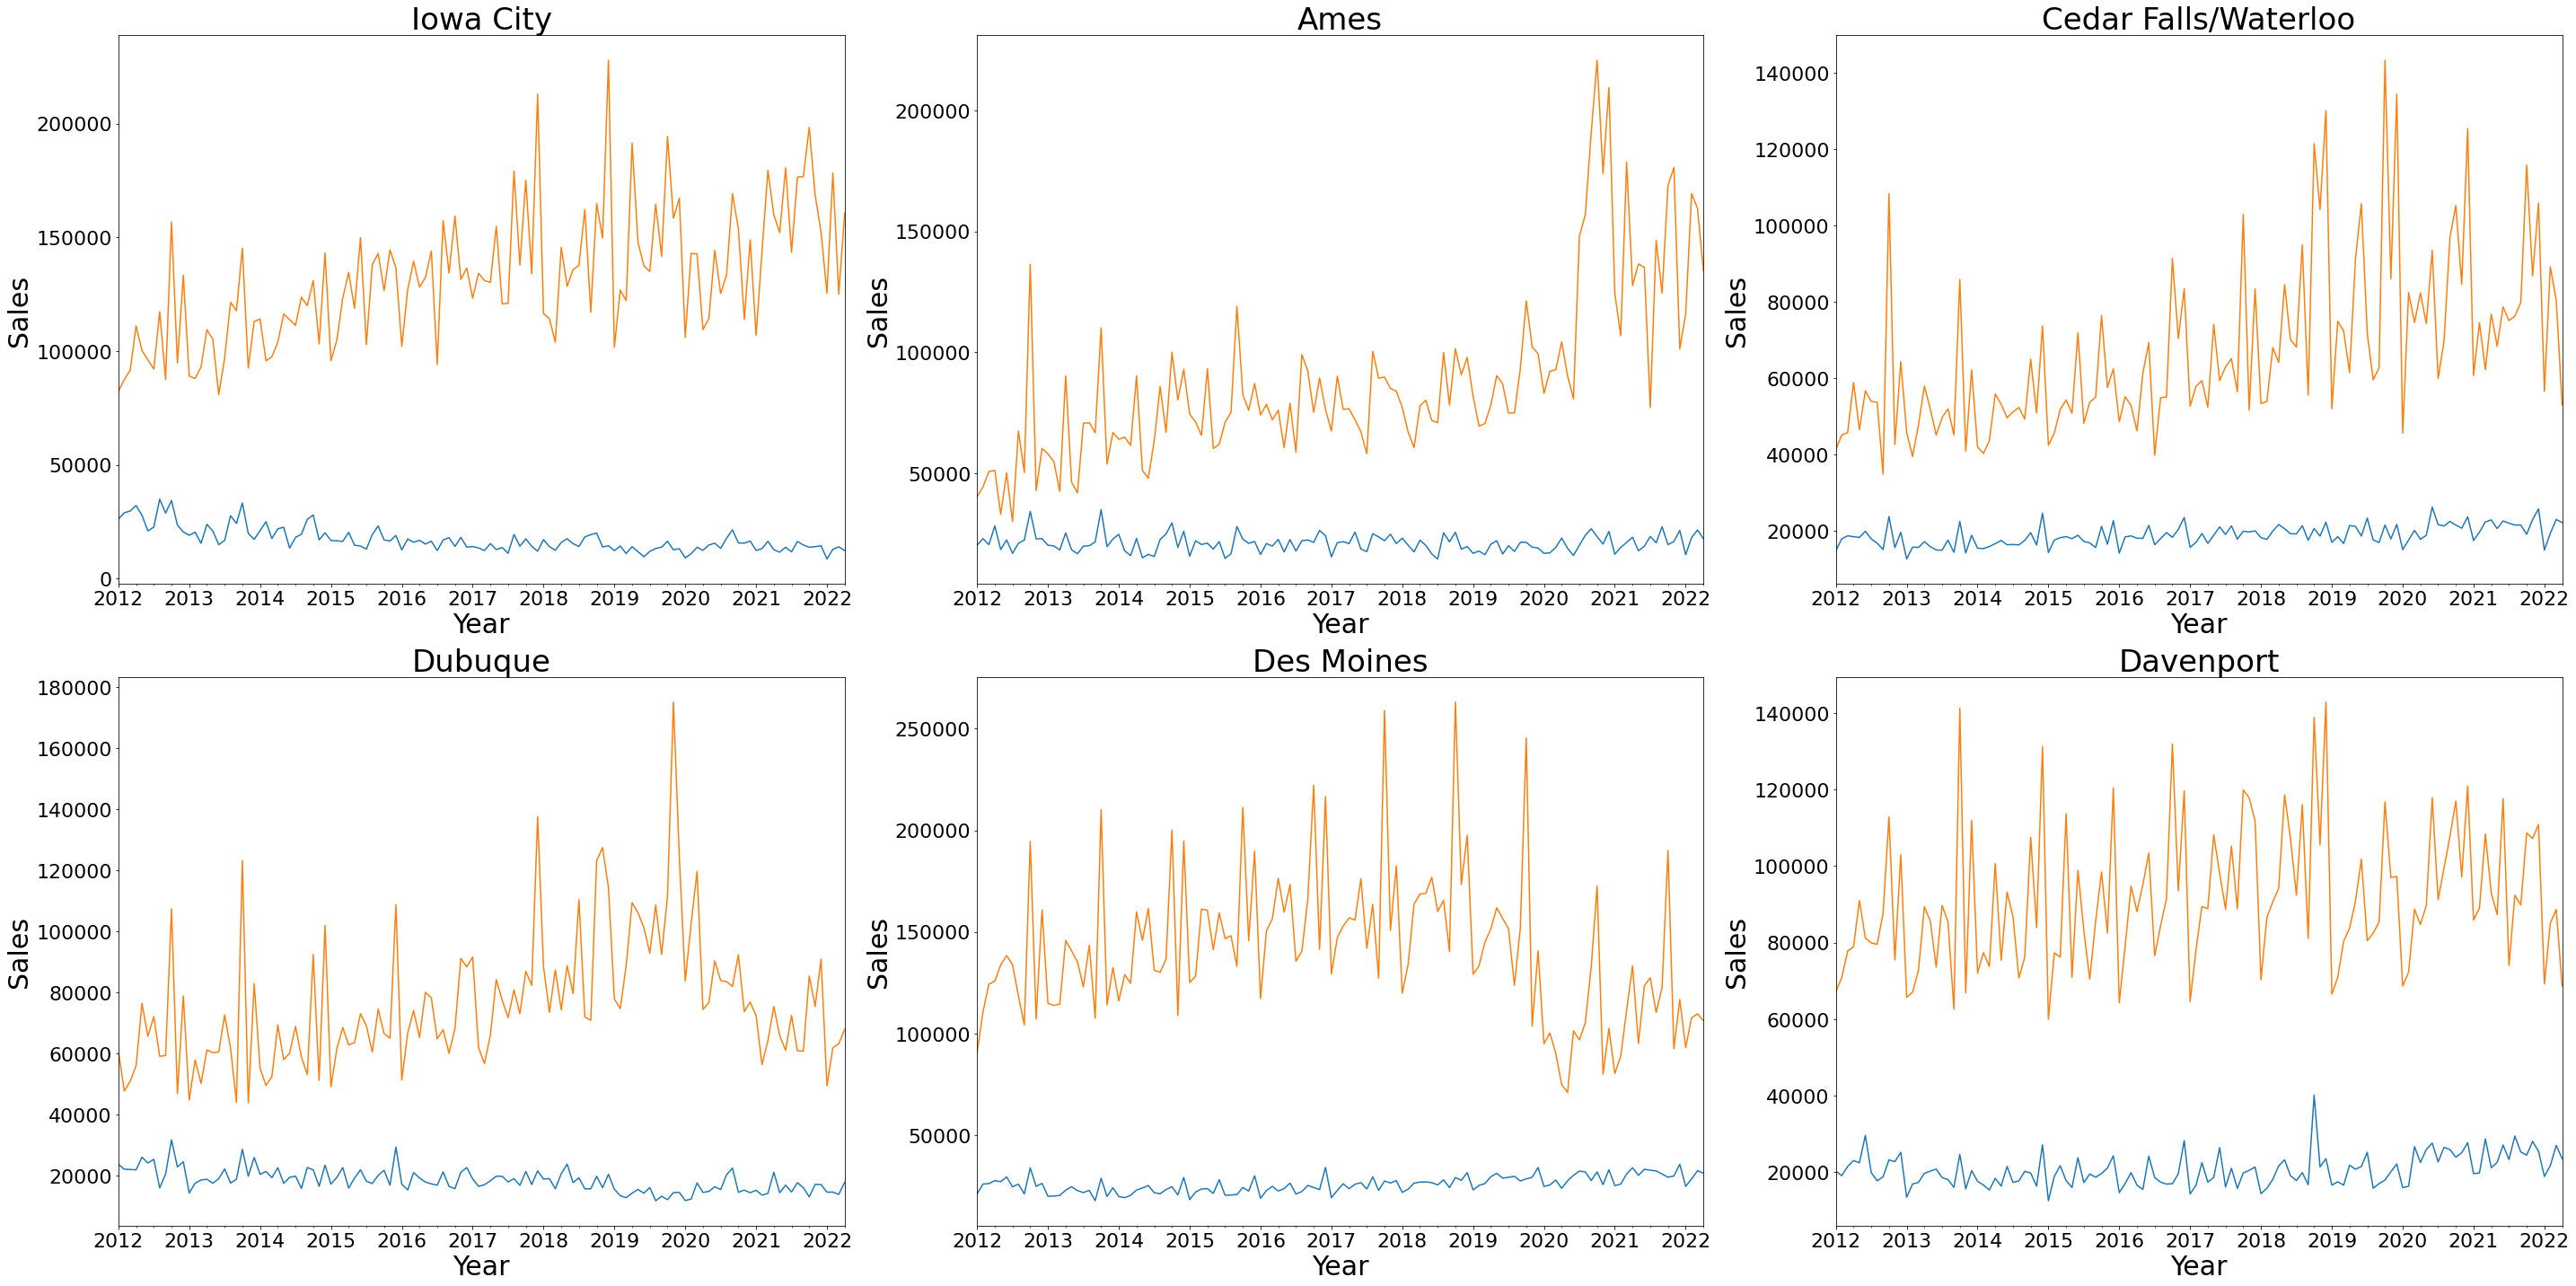

In [586]:
fig, axs = plt.subplots(nrows= 2, ncols=3, figsize=(40,20))
ax = axs.ravel()

for i, zip_code, town in zip(range(0,6), [iowa_city_zips, ames_zips,
                            cedar_waterloo_zips,dubuque_zips,
                            des_moines_zc, davenport_zips], college_towns):
    totalStores = c_transactions[c_transactions["ZipCode"].isin(zip_code)]
    totalStores = totalStores.groupby(['Hyvee?','StoreNumber', pd.Grouper(key='Date', freq='M')])['Sale'].sum()
    totalSales = totalStores.reset_index().groupby(['Date', 'Hyvee?']).agg(Sale=('Sale','sum'))
    totalStores = totalStores.reset_index().groupby(['Date', 'Hyvee?']).agg(Stores=('StoreNumber', 'count'))
    avg_sales_per_store = totalSales.Sale/totalStores.Stores
    pd.DataFrame(avg_sales_per_store,index=totalStores.index).unstack().plot(ax=ax[i], legend = None, title=town, fontsize = 22)
    ax[i].set_ylabel('Sales',fontdict={'fontsize':30})
    ax[i].set_xlabel('Year',fontdict={'fontsize':30} )
    ax[i].set_title(town, fontsize = 34)
plt.tight_layout()
plt.show()



In [154]:
x = transactionsdf[["Date", "StoreNumber", "Sale"]]

In [155]:
x = x[x['StoreNumber'].isin(store_HyVeeC.StoreNumber)]

In [156]:
x

Date  StoreNumber    Sale
InvoiceNumber                                   
S03411000130     2012-01-03         2625   23.12
S03393400052     2012-01-03         2624  138.72
S03410900138     2012-01-03         2649   69.92
S03411000008     2012-01-03         2625  134.28
S03410900014     2012-01-03         2649   98.40
...                     ...          ...     ...
INV-46968300130  2022-04-29         2649   47.00
INV-46968200029  2022-04-29         2524   87.00
INV-46968300070  2022-04-29         2649   45.48
INV-46968200020  2022-04-29         2524   52.50
INV-46968300023  2022-04-29         2649  103.50

[2492086 rows x 3 columns]

In [14]:
sales = pd.merge(transactionsdf[["Date", "StoreNumber", "Sale"]], store_HyVeeC, on = 'StoreNumber')
# sales = sales[['Date', 'StoreNumber', 'StoreName', 'City', 'Sale']]
sales['City'].value_counts()

Des Moines         660109
Davenport          455230
Iowa City          328080
Waterloo           244890
Dubuque            232029
Ames               228772
Cedar Falls        125091
Windsor Heights     85013
Urbandale           80074
WATERLOO            24268
CEDAR FALLS         20612
URBANDALE            3665
AMES                 3490
Clive                 571
Johnston              192
Name: City, dtype: int64

In [66]:
sales[sales['Sale'] > 400]

Date  StoreNumber                             StoreName       City  \
199      2012         2625  Hy-Vee Wine & Spirits #2 / Davenport  Davenport   
208      2012         2625  Hy-Vee Wine & Spirits #2 / Davenport  Davenport   
619      2013         2625  Hy-Vee Wine & Spirits #2 / Davenport  Davenport   
634      2013         2625  Hy-Vee Wine & Spirits #2 / Davenport  Davenport   
927      2013         2625  Hy-Vee Wine & Spirits #2 / Davenport  Davenport   
...       ...          ...                                   ...        ...   
6898879  2015         9018           Paradise Distilling Company    Dubuque   
6898880  2015         9018           Paradise Distilling Company    Dubuque   
6898883  2016         9018           Paradise Distilling Company    Dubuque   
6898884  2016         9018           Paradise Distilling Company    Dubuque   
6898885  2016         9018           Paradise Distilling Company    Dubuque   

            Sale  
199       585.00  
208       585.00  
619       467.52  
634       467.52  
927       900.00  
...          ...  
6898879  8100.00  
6898880  6435.00  
6898883  1800.00  
6898884  1800.00  
6898885  3600.00  

[392616 rows x 5 columns]

In [460]:
sales

Sale
Date City                     
2012 Ames         7.192424e+06
     Cedar Falls  4.779273e+06
     Davenport    1.288240e+07
     Des Moines   3.950571e+07
     Dubuque      7.321691e+06
...                        ...
2022 Davenport    6.490228e+06
     Des Moines   2.034715e+07
     Dubuque      3.311444e+06
     Iowa City    3.946240e+06
     Waterloo     4.445435e+06

[77 rows x 1 columns]

In [496]:
sales = pd.merge(c_transactions[["Date", "StoreNumber", "Sale"]], college_storesdf, on = 'StoreNumber')
sales = sales[['Date', 'StoreNumber', 'StoreName','ZipCode', 'City', 'Sale']]
sales.loc[sales.ZipCode.isin(cedar_waterloo_zips), 'City'] = 'Cedar Falls/Waterloo'

sales['Date'] = pd.to_datetime(sales['Date'], 
                                        infer_datetime_format=True)
sales['Date'] = sales['Date'].dt.year.astype(int)
sales = sales[['Date', 'City', 'Sale']]
sales = sales.groupby(['Date', 'City']).agg({'Sale': 'sum'})
dft = sales.pivot_table(values = 'Sale',index = ['Date'],columns = 'City')
dft.sort_values(list(dft.columns),inplace=True)
dft = dft.sort_index()
dft.iloc[:, :] = dft.iloc[:, :].cumsum()
dft

City          Ames  Cedar Falls/Waterloo     Davenport    Des Moines  \
Date                                                                   
2012  7.192424e+06          1.505283e+07  1.288240e+07  3.950571e+07   
2013  1.434013e+07          2.996672e+07  2.582560e+07  7.975126e+07   
2014  2.196332e+07          4.537818e+07  3.954348e+07  1.226152e+08   
2015  2.970887e+07          6.110247e+07  5.372102e+07  1.679216e+08   
2016  3.780332e+07          7.769402e+07  6.894304e+07  2.162484e+08   
2017  4.616138e+07          9.470664e+07  8.462814e+07  2.679089e+08   
2018  5.499409e+07          1.130307e+08  1.022010e+08  3.219153e+08   
2019  6.404989e+07          1.320107e+08  1.198969e+08  3.788609e+08   
2020  7.491381e+07          1.531636e+08  1.412845e+08  4.351513e+08   
2021  8.657441e+07          1.765034e+08  1.629936e+08  4.993280e+08   
2022  9.037173e+07          1.836348e+08  1.694838e+08  5.196751e+08   

City       Dubuque     Iowa City  
Date                              
2012  7.321691e+06  9.370466e+06  
2013  1.450688e+07  1.865583e+07  
2014  2.195245e+07  2.860541e+07  
2015  2.985914e+07  3.899627e+07  
2016  3.794829e+07  4.937107e+07  
2017  4.657767e+07  6.017920e+07  
2018  5.629896e+07  7.116093e+07  
2019  6.558766e+07  8.187354e+07  
2020  7.567708e+07  9.305797e+07  
2021  8.655600e+07  1.055498e+08  
2022  8.986744e+07  1.094961e+08

In [501]:
import bar_chart_race as bcr
bcr.bar_chart_race(df = dft, 
                   n_bars = 6,
                   period_length = 3500,
                   bar_size = 0.85,
                   steps_per_period = 45,
                   sort='desc',
                   title=' Liquor Sales since 2012')

In [232]:
top_hyvee = transactions_2019_2022[transactions_2019_2022['StoreNumber'].isin(store_HyVeeC.StoreNumber)]
top_hyvee = top_hyvee.merge(storesdf, on = 'StoreNumber')
top_hyvee[top_hyvee['StoreNumber']== 2633]



Date  StoreNumber  Category  VendorNumber  ItemNumber  \
273134 2019-01-02         2633   1081400            65       73517   
273135 2019-01-02         2633   1081300            65       73533   
273136 2019-01-02         2633   1031200           260       77375   
273137 2019-01-02         2633   1012200            35        4876   
273138 2019-01-02         2633   1012300           420        5067   
...           ...          ...       ...           ...         ...   
333465 2022-04-28         2633   1082200           421       69657   
333466 2022-04-28         2633   1022200           255       87385   
333467 2022-04-29         2633   1091200            35       64736   
333468 2022-04-29         2633   1052100           420      948167   
333469 2022-04-29         2633   1011100           391       15961   

        BottlesSold  Volume(Gallons)     Sale                     StoreName  \
273134            0              NaN    11.81  Hy-Vee #3 / BDI / Des Moines   
273135            0              NaN    18.11  Hy-Vee #3 / BDI / Des Moines   
273136            0              NaN    49.52  Hy-Vee #3 / BDI / Des Moines   
273137            0              NaN    30.00  Hy-Vee #3 / BDI / Des Moines   
273138            0              NaN   149.99  Hy-Vee #3 / BDI / Des Moines   
...             ...              ...      ...                           ...   
333465          288              NaN  4752.00  Hy-Vee #3 / BDI / Des Moines   
333466           12              NaN   287.88  Hy-Vee #3 / BDI / Des Moines   
333467          120              NaN  2551.20  Hy-Vee #3 / BDI / Des Moines   
333468           30              NaN  2699.70  Hy-Vee #3 / BDI / Des Moines   
333469           12              NaN   864.00  Hy-Vee #3 / BDI / Des Moines   

              City  ZipCode  CountyNumber County  
273134  Des Moines    50320          77.0   POLK  
273135  Des Moines    50320          77.0   POLK  
273136  Des Moines    50320          77.0   POLK  
273137  Des Moines    50320          77.0   POLK  
273138  Des Moines    50320          77.0   POLK  
...            ...      ...           ...    ...  
333465  Des Moines    50320          77.0   POLK  
333466  Des Moines    50320          77.0   POLK  
333467  Des Moines    50320          77.0   POLK  
333468  Des Moines    50320          77.0   POLK  
333469  Des Moines    50320          77.0   POLK  

[60336 rows x 13 columns]

# Top hyvee stores

In [286]:
top_hyvee = transactions_2019_2022[transactions_2019_2022['StoreNumber'].isin(store_HyVeeC.StoreNumber)]

top_hyvee = top_hyvee.merge(storesdf, on = 'StoreNumber')

top_hyvee = top_hyvee[top_hyvee['ZipCode'].isin(davenport_zips)]
top_hyvee = top_hyvee.groupby([pd.Grouper(key='Date', freq='Y'),'City','StoreNumber']).agg({'Sale': 'sum'})

top_hyvee.sort_values(by = ['Date','Sale'], ascending = False).head(40)



Sale
Date       City      StoreNumber            
2022-12-31 Davenport 2614          687040.22
                     2625          554910.00
                     2635          454045.43
                     2637          276920.95
                     2567          174858.57
                     2554           59124.86
                     2678           41340.31
                     2722            1126.94
2021-12-31 Davenport 2614         2364356.69
                     2625         2217022.29
                     2635         1660537.99
                     2637         1007736.74
                     2567          542635.48
                     2554          211336.87
                     2678          144034.76
2020-12-31 Davenport 2614         2223059.48
                     2625         2006567.48
                     2635         1829253.06
                     2637         1095779.51
                     2567          546611.79
                     2554          241832.50
                     2678          143375.68
2019-12-31 Davenport 2625         2543035.65
                     2614         1745814.33
                     2635         1369626.13
                     2637          946376.04
                     2567          449025.86
                     2554          239478.16
                     2678           80342.27

In [636]:
storesdf[storesdf['StoreNumber']== 4196]


StoreNumber                        StoreName       City  ZipCode  \
674         4196  Fareway Stores #987 / Davenport  Davenport    52806   

     CountyNumber County  
674          82.0  SCOTT

# Top not hyvee stores

In [634]:
top_not_hyvee = transactions_2019_2022[~transactions_2019_2022['StoreNumber'].isin(store_HyVeeC.StoreNumber)]

top_not_hyvee = top_not_hyvee.merge(storesdf, on = 'StoreNumber')

top_not_hyvee = top_not_hyvee[top_not_hyvee['ZipCode'].isin(davenport_zips)]


top_not_hyvee = top_not_hyvee.groupby([pd.Grouper(key='Date', freq='Y'),'City','StoreNumber']).agg({'Sale': 'sum'})

top_not_hyvee.sort_values(by = ['Sale'], ascending = False).head(40)




Sale
Date       City      StoreNumber            
2020-12-31 Davenport 3354         2468150.57
2019-12-31 Davenport 3354         2387732.10
2021-12-31 Davenport 3354         2386378.59
                     5666         1778484.71
2020-12-31 Davenport 5666         1495377.18
2022-12-31 Davenport 3354          825364.44
2019-12-31 Davenport 5666          799177.41
2020-12-31 Davenport 4196          670893.85
                     3731          602516.70
2021-12-31 Davenport 4196          591481.82
2022-12-31 Davenport 5666          572008.58
2021-12-31 Davenport 3731          555106.37
2019-12-31 Davenport 3731          540513.78
                     4196          511240.11
2020-12-31 Davenport 4638          481943.59
                     4640          451999.24
2021-12-31 Davenport 4638          431352.10
2019-12-31 Davenport 4638          427388.46
2020-12-31 Davenport 5678          420188.72
                     3805          416462.18
2019-12-31 Davenport 3776          410598.65
2020-12-31 Davenport 5029          407008.83
                     3776          406272.95
2021-12-31 Davenport 5678          404033.15
                     3776          380304.95
                     4640          363148.55
                     3805          360319.48
                     5029          349707.46
                     4652          340337.24
2020-12-31 Davenport 5003          336382.08
2021-12-31 Davenport 5198          336102.28
2020-12-31 Davenport 5559          333761.55
2019-12-31 Davenport 5678          316950.55
                     5029          316350.42
2021-12-31 Davenport 5003          309298.89
                     5559          300903.30
2020-12-31 Davenport 5198          295729.08
2021-12-31 Davenport 4962          293550.20
2020-12-31 Davenport 3540          289476.24
                     3858          279827.60

# Analysis of store 3354 davenport sam's club

In [649]:
item = transactions_2019_2022.groupby('ItemNumber').sum().sort_values(by='Sale', ascending=False)
item = item.reset_index()[['ItemNumber', 'Sale']]
item = item.sort_values(by='Sale', ascending=False)
item = item.loc[0:100,]
item.drop(columns='Sale', inplace=True)
item = item.astype(str)
item = item.merge(productsdf, on='ItemNumber')

store = transactions_2019_2022[transactions_2019_2022.StoreNumber==3354]
store.ItemNumber = store.ItemNumber.astype(str)
store = store.merge(item.reset_index(), on='ItemNumber')
store = store.groupby(['ItemNumber', 'ItemDescription',pd.Grouper(key = 'Date', freq='D')]).agg(Sale=('Sale','sum'))
store = store.pivot_table(values='Sale', index=['Date'], columns=['ItemNumber','ItemDescription'], aggfunc=np.sum)
store.fillna(0, inplace=True)

for col in store.columns:
    store.loc[store[col]>0, col] = 1
store = store.astype(int)

freq_itemsets = apriori(store, min_support=0.55, use_colnames=True, max_len=2)
rules = association_rules(freq_itemsets, metric="lift")
rules[(rules['lift']>.1) & (rules['confidence']>0.1)]

antecedents  \
0                         ((43127, Bacardi Superior))   
1                         ((25608, Seagrams 7 Crown))   
2                     ((65257, Jagermeister Liqueur))   
3                         ((25608, Seagrams 7 Crown))   
4   ((69947, Rumple Minze Peppermint Schnapps Liqu...   
5                         ((25608, Seagrams 7 Crown))   
6                         ((43127, Bacardi Superior))   
7                     ((65257, Jagermeister Liqueur))   
8   ((69947, Rumple Minze Peppermint Schnapps Liqu...   
9                     ((65257, Jagermeister Liqueur))   
10                    ((65257, Jagermeister Liqueur))   
11             ((82847, Dekuyper Luscious Peachtree))   
12  ((69947, Rumple Minze Peppermint Schnapps Liqu...   
13             ((82847, Dekuyper Luscious Peachtree))   

                                          consequents  antecedent support  \
0                         ((25608, Seagrams 7 Crown))            0.705882   
1                         ((43127, Bacardi Superior))            0.752941   
2                         ((25608, Seagrams 7 Crown))            0.811765   
3                     ((65257, Jagermeister Liqueur))            0.752941   
4                         ((25608, Seagrams 7 Crown))            0.723529   
5   ((69947, Rumple Minze Peppermint Schnapps Liqu...            0.752941   
6                     ((65257, Jagermeister Liqueur))            0.705882   
7                         ((43127, Bacardi Superior))            0.811765   
8                     ((65257, Jagermeister Liqueur))            0.723529   
9   ((69947, Rumple Minze Peppermint Schnapps Liqu...            0.811765   
10             ((82847, Dekuyper Luscious Peachtree))            0.811765   
11                    ((65257, Jagermeister Liqueur))            0.664706   
12             ((82847, Dekuyper Luscious Peachtree))            0.723529   
13  ((69947, Rumple Minze Peppermint Schnapps Liqu...            0.664706   

    consequent support   support  confidence      lift  leverage  conviction  
0             0.752941  0.552941    0.783333  1.040365  0.021453    1.140271  
1             0.705882  0.552941    0.734375  1.040365  0.021453    1.107266  
2             0.752941  0.647059    0.797101  1.058650  0.035848    1.217647  
3             0.811765  0.647059    0.859375  1.058650  0.035848    1.338562  
4             0.752941  0.594118    0.821138  1.090574  0.049343    1.381283  
5             0.723529  0.594118    0.789062  1.090574  0.049343    1.310675  
6             0.811765  0.600000    0.850000  1.047101  0.026990    1.254902  
7             0.705882  0.600000    0.739130  1.047101  0.026990    1.127451  
8             0.811765  0.658824    0.910569  1.121716  0.071488    2.104813  
9             0.723529  0.658824    0.811594  1.121716  0.071488    1.467421  
10            0.664706  0.576471    0.710145  1.068360  0.036886    1.156765  
11            0.811765  0.576471    0.867257  1.068360  0.036886    1.418039  
12            0.664706  0.552941    0.764228  1.149723  0.072007    1.422110  
13            0.723529  0.552941    0.831858  1.149723  0.072007    1.644272

In [650]:
rules.sort_values('confidence', ascending = False, inplace = True)
rules[['antecedents', 'consequents','support','confidence']].head(20).reset_index(drop = True)

antecedents  \
0   ((69947, Rumple Minze Peppermint Schnapps Liqu...   
1              ((82847, Dekuyper Luscious Peachtree))   
2                         ((25608, Seagrams 7 Crown))   
3                         ((43127, Bacardi Superior))   
4              ((82847, Dekuyper Luscious Peachtree))   
5   ((69947, Rumple Minze Peppermint Schnapps Liqu...   
6                     ((65257, Jagermeister Liqueur))   
7                     ((65257, Jagermeister Liqueur))   
8                         ((25608, Seagrams 7 Crown))   
9                         ((43127, Bacardi Superior))   
10  ((69947, Rumple Minze Peppermint Schnapps Liqu...   
11                    ((65257, Jagermeister Liqueur))   
12                        ((25608, Seagrams 7 Crown))   
13                    ((65257, Jagermeister Liqueur))   

                                          consequents   support  confidence  
0                     ((65257, Jagermeister Liqueur))  0.658824    0.910569  
1                     ((65257, Jagermeister Liqueur))  0.576471    0.867257  
2                     ((65257, Jagermeister Liqueur))  0.647059    0.859375  
3                     ((65257, Jagermeister Liqueur))  0.600000    0.850000  
4   ((69947, Rumple Minze Peppermint Schnapps Liqu...  0.552941    0.831858  
5                         ((25608, Seagrams 7 Crown))  0.594118    0.821138  
6   ((69947, Rumple Minze Peppermint Schnapps Liqu...  0.658824    0.811594  
7                         ((25608, Seagrams 7 Crown))  0.647059    0.797101  
8   ((69947, Rumple Minze Peppermint Schnapps Liqu...  0.594118    0.789062  
9                         ((25608, Seagrams 7 Crown))  0.552941    0.783333  
10             ((82847, Dekuyper Luscious Peachtree))  0.552941    0.764228  
11                        ((43127, Bacardi Superior))  0.600000    0.739130  
12                        ((43127, Bacardi Superior))  0.552941    0.734375  
13             ((82847, Dekuyper Luscious Peachtree))  0.576471    0.710145

# Analysis of store 5666 davenport Costco


In [282]:
item = transactions_2019_2022.groupby('ItemNumber').sum().sort_values(by='Sale', ascending=False)
item = item.reset_index()[['ItemNumber', 'Sale']]
item = item.sort_values(by='Sale', ascending=False)
item = item.loc[0:100,]
item.drop(columns='Sale', inplace=True)
item = item.astype(str)
item = item.merge(productsdf, on='ItemNumber')

store = transactions_2019_2022[transactions_2019_2022.StoreNumber== 5666]
store.ItemNumber = store.ItemNumber.astype(str)
store = store.merge(item.reset_index(), on='ItemNumber')
store = store.groupby(['ItemNumber', 'ItemDescription',pd.Grouper(key = 'Date', freq='D')]).agg(Sale=('Sale','sum'))
store = store.pivot_table(values='Sale', index=['Date'], columns=['ItemNumber','ItemDescription'], aggfunc=np.sum)
store.fillna(0, inplace=True)

for col in store.columns:
    store.loc[store[col]>0, col] = 1
store = store.astype(int)

freq_itemsets = apriori(store, min_support=0.1, use_colnames=True, max_len=2)
rules = association_rules(freq_itemsets, metric="lift")
rules[(rules['lift']>.1) & (rules['confidence']>0.1)]

antecedents  \
0                    ((16676, Basil Hayden 8YR))   
1  ((936600, Kirkland Signature American Vodka))   
2                ((38178, Titos Handmade Vodka))   
3                 ((17206, Cedar Ridge Bourbon))   
4                            ((19068, Jim Beam))   
5                ((38178, Titos Handmade Vodka))   
6                   ((27102, Templeton Rye 4YR))   
7                ((38178, Titos Handmade Vodka))   
8                    ((43128, Bacardi Superior))   
9                ((38178, Titos Handmade Vodka))   

                                     consequents  antecedent support  \
0  ((936600, Kirkland Signature American Vodka))            0.171429   
1                    ((16676, Basil Hayden 8YR))            0.421429   
2                 ((17206, Cedar Ridge Bourbon))            0.371429   
3                ((38178, Titos Handmade Vodka))            0.150000   
4                ((38178, Titos Handmade Vodka))            0.157143   
5                            ((19068, Jim Beam))            0.371429   
6                ((38178, Titos Handmade Vodka))            0.185714   
7                   ((27102, Templeton Rye 4YR))            0.371429   
8                ((38178, Titos Handmade Vodka))            0.157143   
9                    ((43128, Bacardi Superior))            0.371429   

   consequent support   support  confidence      lift  leverage  conviction  
0            0.421429  0.100000    0.583333  1.384181  0.027755    1.388571  
1            0.171429  0.100000    0.237288  1.384181  0.027755    1.086349  
2            0.150000  0.107143    0.288462  1.923077  0.051429    1.194595  
3            0.371429  0.107143    0.714286  1.923077  0.051429    2.200000  
4            0.371429  0.107143    0.681818  1.835664  0.048776    1.975510  
5            0.157143  0.107143    0.288462  1.835664  0.048776    1.184556  
6            0.371429  0.114286    0.615385  1.656805  0.045306    1.634286  
7            0.185714  0.114286    0.307692  1.656805  0.045306    1.176190  
8            0.371429  0.114286    0.727273  1.958042  0.055918    2.304762  
9            0.157143  0.114286    0.307692  1.958042  0.055918    1.217460

In [283]:
rules.sort_values('confidence', ascending = False, inplace = True)
rules[['antecedents', 'consequents','support','confidence']].head(20).reset_index(drop = True)


antecedents  \
0                    ((43128, Bacardi Superior))   
1                 ((17206, Cedar Ridge Bourbon))   
2                            ((19068, Jim Beam))   
3                   ((27102, Templeton Rye 4YR))   
4                    ((16676, Basil Hayden 8YR))   
5                ((38178, Titos Handmade Vodka))   
6                ((38178, Titos Handmade Vodka))   
7                ((38178, Titos Handmade Vodka))   
8                ((38178, Titos Handmade Vodka))   
9  ((936600, Kirkland Signature American Vodka))   

                                     consequents   support  confidence  
0                ((38178, Titos Handmade Vodka))  0.114286    0.727273  
1                ((38178, Titos Handmade Vodka))  0.107143    0.714286  
2                ((38178, Titos Handmade Vodka))  0.107143    0.681818  
3                ((38178, Titos Handmade Vodka))  0.114286    0.615385  
4  ((936600, Kirkland Signature American Vodka))  0.100000    0.583333  
5                   ((27102, Templeton Rye 4YR))  0.114286    0.307692  
6                    ((43128, Bacardi Superior))  0.114286    0.307692  
7                 ((17206, Cedar Ridge Bourbon))  0.107143    0.288462  
8                            ((19068, Jim Beam))  0.107143    0.288462  
9                    ((16676, Basil Hayden 8YR))  0.100000    0.237288

# analysis of Happy's Wine and spirits 4988 waterloo

In [631]:
item = transactions_2019_2022.groupby('ItemNumber').sum().sort_values(by='Sale', ascending=False)
item = item.reset_index()[['ItemNumber', 'Sale']]
item = item.sort_values(by='Sale', ascending=False)
item = item.loc[0:100,]
item.drop(columns='Sale', inplace=True)
item = item.astype(str)
item = item.merge(productsdf, on='ItemNumber')

store = transactions_2019_2022[transactions_2019_2022.StoreNumber==4988]
store.ItemNumber = store.ItemNumber.astype(str)
store = store.merge(item.reset_index(), on='ItemNumber')
store = store.groupby(['ItemNumber', 'ItemDescription',pd.Grouper(key = 'Date', freq='D')]).agg(Sale=('Sale','sum'))
store = store.pivot_table(values='Sale', index=['Date'], columns=['ItemNumber','ItemDescription'], aggfunc=np.sum)
store.fillna(0, inplace=True)

for col in store.columns:
    store.loc[store[col]>0, col] = 1
store = store.astype(int)

freq_itemsets = apriori(store, min_support=0.66, use_colnames=True, max_len=2)
rules = association_rules(freq_itemsets, metric="lift")
rules[(rules['lift']>.1) & (rules['confidence']>0.1)]


antecedents  \
0                              ((11297, Crown Royal))   
1                     ((38177, Titos Handmade Vodka))   
2                ((64867, Fireball Cinnamon Whiskey))   
3                              ((11297, Crown Royal))   
4   ((69947, Rumple Minze Peppermint Schnapps Liqu...   
5                              ((11297, Crown Royal))   
6   ((69947, Rumple Minze Peppermint Schnapps Liqu...   
7                     ((38177, Titos Handmade Vodka))   
8   ((69947, Rumple Minze Peppermint Schnapps Liqu...   
9           ((43337, Captain Morgan Original Spiced))   
10  ((69947, Rumple Minze Peppermint Schnapps Liqu...   
11               ((64867, Fireball Cinnamon Whiskey))   

                                          consequents  antecedent support  \
0                     ((38177, Titos Handmade Vodka))            0.747423   
1                              ((11297, Crown Royal))            0.752577   
2                              ((11297, Crown Royal))            0.742268   
3                ((64867, Fireball Cinnamon Whiskey))            0.747423   
4                              ((11297, Crown Royal))            0.768041   
5   ((69947, Rumple Minze Peppermint Schnapps Liqu...            0.747423   
6                     ((38177, Titos Handmade Vodka))            0.768041   
7   ((69947, Rumple Minze Peppermint Schnapps Liqu...            0.752577   
8           ((43337, Captain Morgan Original Spiced))            0.768041   
9   ((69947, Rumple Minze Peppermint Schnapps Liqu...            0.752577   
10               ((64867, Fireball Cinnamon Whiskey))            0.768041   
11  ((69947, Rumple Minze Peppermint Schnapps Liqu...            0.742268   

    consequent support   support  confidence      lift  leverage  conviction  
0             0.752577  0.670103    0.896552  1.191308  0.107610    2.391753  
1             0.747423  0.670103    0.890411  1.191308  0.107610    2.304768  
2             0.747423  0.664948    0.895833  1.198563  0.110160    2.424742  
3             0.742268  0.664948    0.889655  1.198563  0.110160    2.335696  
4             0.747423  0.680412    0.885906  1.185281  0.106361    2.213766  
5             0.768041  0.680412    0.910345  1.185281  0.106361    2.587232  
6             0.752577  0.675258    0.879195  1.168245  0.097247    2.048110  
7             0.768041  0.675258    0.897260  1.168245  0.097247    2.257732  
8             0.752577  0.664948    0.865772  1.150409  0.086938    1.843299  
9             0.768041  0.664948    0.883562  1.150409  0.086938    1.992116  
10            0.742268  0.670103    0.872483  1.175429  0.100011    2.021161  
11            0.768041  0.670103    0.902778  1.175429  0.100011    2.385862

In [633]:
rules.sort_values('confidence', ascending = False, inplace = True)
rules[['antecedents', 'consequents','support','confidence']].head(10).reset_index(drop = True)


antecedents  \
0                             ((11297, Crown Royal))   
1               ((64867, Fireball Cinnamon Whiskey))   
2                    ((38177, Titos Handmade Vodka))   
3                             ((11297, Crown Royal))   
4               ((64867, Fireball Cinnamon Whiskey))   
5                    ((38177, Titos Handmade Vodka))   
6                             ((11297, Crown Royal))   
7  ((69947, Rumple Minze Peppermint Schnapps Liqu...   
8          ((43337, Captain Morgan Original Spiced))   
9  ((69947, Rumple Minze Peppermint Schnapps Liqu...   

                                         consequents   support  confidence  
0  ((69947, Rumple Minze Peppermint Schnapps Liqu...  0.680412    0.910345  
1  ((69947, Rumple Minze Peppermint Schnapps Liqu...  0.670103    0.902778  
2  ((69947, Rumple Minze Peppermint Schnapps Liqu...  0.675258    0.897260  
3                    ((38177, Titos Handmade Vodka))  0.670103    0.896552  
4                             ((11297, Crown Royal))  0.664948    0.895833  
5                             ((11297, Crown Royal))  0.670103    0.890411  
6               ((64867, Fireball Cinnamon Whiskey))  0.664948    0.889655  
7                             ((11297, Crown Royal))  0.680412    0.885906  
8  ((69947, Rumple Minze Peppermint Schnapps Liqu...  0.664948    0.883562  
9                    ((38177, Titos Handmade Vodka))  0.675258    0.879195

# davenport 2614 hyvee

In [321]:
item = transactions_2019_2022.groupby('ItemNumber').sum().sort_values(by='Sale', ascending=False)
item = item.reset_index()[['ItemNumber', 'Sale']]
item = item.sort_values(by='Sale', ascending=False)
item = item.loc[0:100,]
item.drop(columns='Sale', inplace=True)
item = item.astype(str)
item = item.merge(productsdf, on='ItemNumber')

store = transactions_2019_2022[transactions_2019_2022.StoreNumber==2625]
store.ItemNumber = store.ItemNumber.astype(str)
store = store.merge(item.reset_index(), on='ItemNumber')
store = store.groupby(['ItemNumber', 'ItemDescription',pd.Grouper(key = 'Date', freq='D')]).agg(Sale=('Sale','sum'))
store = store.pivot_table(values='Sale', index=['Date'], columns=['ItemNumber','ItemDescription'], aggfunc=np.sum)
store.fillna(0, inplace=True)

for col in store.columns:
    store.loc[store[col]>0, col] = 1
store = store.astype(int)

freq_itemsets = apriori(store, min_support=0.6, use_colnames=True, max_len=2)
rules = association_rules(freq_itemsets, metric="lift")
rules[(rules['lift']>.1) & (rules['confidence']>0.1)]


antecedents  \
0           ((43337, Captain Morgan Original Spiced))   
1                     ((38177, Titos Handmade Vodka))   
2                ((64867, Fireball Cinnamon Whiskey))   
3                     ((38177, Titos Handmade Vodka))   
4                     ((65257, Jagermeister Liqueur))   
5                     ((38177, Titos Handmade Vodka))   
6                ((64867, Fireball Cinnamon Whiskey))   
7           ((43337, Captain Morgan Original Spiced))   
8                     ((65257, Jagermeister Liqueur))   
9           ((43337, Captain Morgan Original Spiced))   
10               ((64867, Fireball Cinnamon Whiskey))   
11                    ((65257, Jagermeister Liqueur))   
12  ((69947, Rumple Minze Peppermint Schnapps Liqu...   
13                    ((65257, Jagermeister Liqueur))   

                                          consequents  antecedent support  \
0                     ((38177, Titos Handmade Vodka))            0.661017   
1           ((43337, Captain Morgan Original Spiced))            0.648305   
2                     ((38177, Titos Handmade Vodka))            0.665254   
3                ((64867, Fireball Cinnamon Whiskey))            0.648305   
4                     ((38177, Titos Handmade Vodka))            0.677966   
5                     ((65257, Jagermeister Liqueur))            0.648305   
6           ((43337, Captain Morgan Original Spiced))            0.665254   
7                ((64867, Fireball Cinnamon Whiskey))            0.661017   
8           ((43337, Captain Morgan Original Spiced))            0.677966   
9                     ((65257, Jagermeister Liqueur))            0.661017   
10                    ((65257, Jagermeister Liqueur))            0.665254   
11               ((64867, Fireball Cinnamon Whiskey))            0.677966   
12                    ((65257, Jagermeister Liqueur))            0.610169   
13  ((69947, Rumple Minze Peppermint Schnapps Liqu...            0.677966   

    consequent support   support  confidence      lift  leverage  conviction  
0             0.648305  0.601695    0.910256  1.404056  0.173154    3.918886  
1             0.661017  0.601695    0.928105  1.404056  0.173154    4.714946  
2             0.648305  0.610169    0.917197  1.414762  0.178882    4.247392  
3             0.665254  0.610169    0.941176  1.414762  0.178882    5.690678  
4             0.648305  0.622881    0.918750  1.417157  0.183352    4.328553  
5             0.677966  0.622881    0.960784  1.417157  0.183352    8.211864  
6             0.661017  0.618644    0.929936  1.406827  0.178900    4.838213  
7             0.665254  0.618644    0.935897  1.406827  0.178900    5.222034  
8             0.661017  0.631356    0.931250  1.408814  0.183209    4.930663  
9             0.677966  0.631356    0.955128  1.408814  0.183209    7.176755  
10            0.677966  0.652542    0.980892  1.446815  0.201523   16.853107  
11            0.665254  0.652542    0.962500  1.446815  0.201523    8.926554  
12            0.677966  0.601695    0.986111  1.454514  0.188021   23.186441  
13            0.610169  0.601695    0.887500  1.454514  0.188021    3.465160

In [322]:
rules.sort_values('confidence', ascending = False, inplace = True)
rules[['antecedents', 'consequents','support','confidence']].head(10).reset_index(drop = True)


antecedents  \
0  ((69947, Rumple Minze Peppermint Schnapps Liqu...   
1               ((64867, Fireball Cinnamon Whiskey))   
2                    ((65257, Jagermeister Liqueur))   
3                    ((38177, Titos Handmade Vodka))   
4          ((43337, Captain Morgan Original Spiced))   
5                    ((38177, Titos Handmade Vodka))   
6          ((43337, Captain Morgan Original Spiced))   
7                    ((65257, Jagermeister Liqueur))   
8               ((64867, Fireball Cinnamon Whiskey))   
9                    ((38177, Titos Handmade Vodka))   

                                 consequents   support  confidence  
0            ((65257, Jagermeister Liqueur))  0.601695    0.986111  
1            ((65257, Jagermeister Liqueur))  0.652542    0.980892  
2       ((64867, Fireball Cinnamon Whiskey))  0.652542    0.962500  
3            ((65257, Jagermeister Liqueur))  0.622881    0.960784  
4            ((65257, Jagermeister Liqueur))  0.631356    0.955128  
5       ((64867, Fireball Cinnamon Whiskey))  0.610169    0.941176  
6       ((64867, Fireball Cinnamon Whiskey))  0.618644    0.935897  
7  ((43337, Captain Morgan Original Spiced))  0.631356    0.931250  
8  ((43337, Captain Morgan Original Spiced))  0.618644    0.929936  
9  ((43337, Captain Morgan Original Spiced))  0.601695    0.928105

In [323]:
1+1

2